In [1]:
# IPython extension to reload modules before executing user code.
# useful to see immediate results in notebook when modifying imported scripts
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
import sys
import os

# Add the ../py directory to sys.path
# This allows importing modules from the py directory as if they were in the current directory
module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'py'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Verify it works
print(f"Added to path: {module_path}")

Added to path: /Users/eyal/projects/elzurdo/precision-goal/py


In [132]:
# from scipy.stats import beta

from utils_stats import (
    #hdi_ci_limits,
    successes_failures_to_hdi_ci_limits,
)

from utils_viz import (
    #plot_success_rates
    plot_vhlines_lines,
    plot_parity_line,
    plot_multiple_decision_rates_jammed,
    plot_multiple_decision_rates_separate,
    scatter_stop_iter_sample_rate,
    viz_one_sample_results,
    plot_sample_pdf_methods,
    plot_success_by_truth,
    plot_success_by_truth_diff,
    ALGO_COLORS,
    plot_success_by_truth_absolute_and_diff,
    plot_stop_and_conclusive_ratios,
)

from utils_experiments import (
    BinaryAccounting,
    BinomialSimulation,
    BinomialHypothesis,
    stop_decision_multiple_experiments_multiple_methods,
    stats_dict_to_df,
    iteration_counts_to_df,
    sample_all_iterations_results,
    report_success_rates_multiple_algos,
    run_simulations_and_analysis_report, # was called full_analysis

)

from utils_experiments_shared import sims_hypo_dict_to_algo_stats_dfs
    

SEED = 42  # previously called seed

In [5]:
import matplotlib.pyplot as plt
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

FIG_WIDTH, FIG_HEIGHT = 8, 6

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = FIG_WIDTH, FIG_HEIGHT
# plt.rcParams["hatch.linewidth"] = 0.2

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Aux

In [6]:
from collections import Counter

def report_accounting_size(binary_accounting):
    
    n_dict = len(binary_accounting.dict_successes_failures_counter)
    print("Binary Accounting Report")
    print(f"{n_dict:,} elements")
    
    #counts = Counter(binary_accounting.dict_successes_failures_counter.values())
    sums = Counter(k[0] + k[1] for k in binary_accounting.dict_successes_failures_counter.keys())
    if len(sums) > 0:
        most_frequent_value, frequency = sums.most_common(1)[0]
        frac_ = frequency / n_dict
        print(f"Most frequent count value: {most_frequent_value:,} (appears {frequency:,} times (of {n_dict:,} {frac_:.2%}))")

        key_max_sum = max(binary_accounting.dict_successes_failures_counter.keys(), key=lambda t: t[0] + t[1])
        print(f"Max sum {np.sum(key_max_sum):,}")
        print(f"e.g, key {key_max_sum} appears {binary_accounting.dict_successes_failures_counter[key_max_sum]:,} time(s) yiedling {binary_accounting.dict_successes_failures_hdi_limits[key_max_sum]} HDI limits")
        print()
    else:
        print(f"The binary counter is empty")

    #print(, len(binary_accounting.dict_successes_failures_hdi_limits))
    #print(sys.getsizeof(binary_accounting.dict_successes_failures_counter), sys.getsizeof(binary_accounting.dict_successes_failures_hdi_limits))
#report_accounting_size(binary_accounting)

In [7]:
# used for storing an linking to binary calucations already performed
binary_accounting = BinaryAccounting()

print(binary_accounting.dict_successes_failures_counter, binary_accounting.dict_successes_failures_hdi_limits)
report_accounting_size(binary_accounting)

{} {}
Binary Accounting Report
0 elements
The binary counter is empty


# Two Example Experiments

## Hypothesis Generation

In [8]:
null_rate_fair = 0.5
dsuccess_rate = 0.05
rope_precision_fraction = 0.8

In [9]:
hypothesis_0pt5 = BinomialHypothesis(
    success_rate_null=null_rate_fair, 
    dsuccess_rate=dsuccess_rate, 
    rope_precision_fraction=rope_precision_fraction)

0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


## Experiments

In [11]:
N_EXPERIMENTS = 2000
N_SAMPLES = 1500  # in paper called M

## Fair Coin ($\theta_{\rm true} = 0.5$)

In [12]:
fair_coin_rate = 0.5

In [13]:
%%time

synth_0pt5 = BinomialSimulation(
    success_rate=fair_coin_rate,
    n_samples = N_SAMPLES,
    n_experiments = N_EXPERIMENTS,
    seed=SEED)

Generating synthetic data with parameter values:
0.5: true success rate
2000: experiments
1500: sample size per experiment
CPU times: user 69.8 ms, sys: 5.14 ms, total: 74.9 ms
Wall time: 76.5 ms


In [14]:
%%time
hypothesis_0pt5.run_hypothesis_on_experiments(synth_0pt5.experiments, binary_accounting)

report_accounting_size(binary_accounting)

,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.9210,0.061,0.9820,0.0180,592.9835,290.737790,0.498253,0.051782
pitg,0.3670,0.000,0.3670,0.6330,598.2090,1.457526,0.499978,0.020554
epitg,0.9765,0.000,0.9765,0.0235,740.9665,221.187573,0.500032,0.013120


Binary Accounting Report
78,501 elements
Most frequent count value: 593 (appears 78 times (of 78,501 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 1 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

CPU times: user 6min 11s, sys: 1.84 s, total: 6min 13s
Wall time: 6min 16s


viz_epitg separate


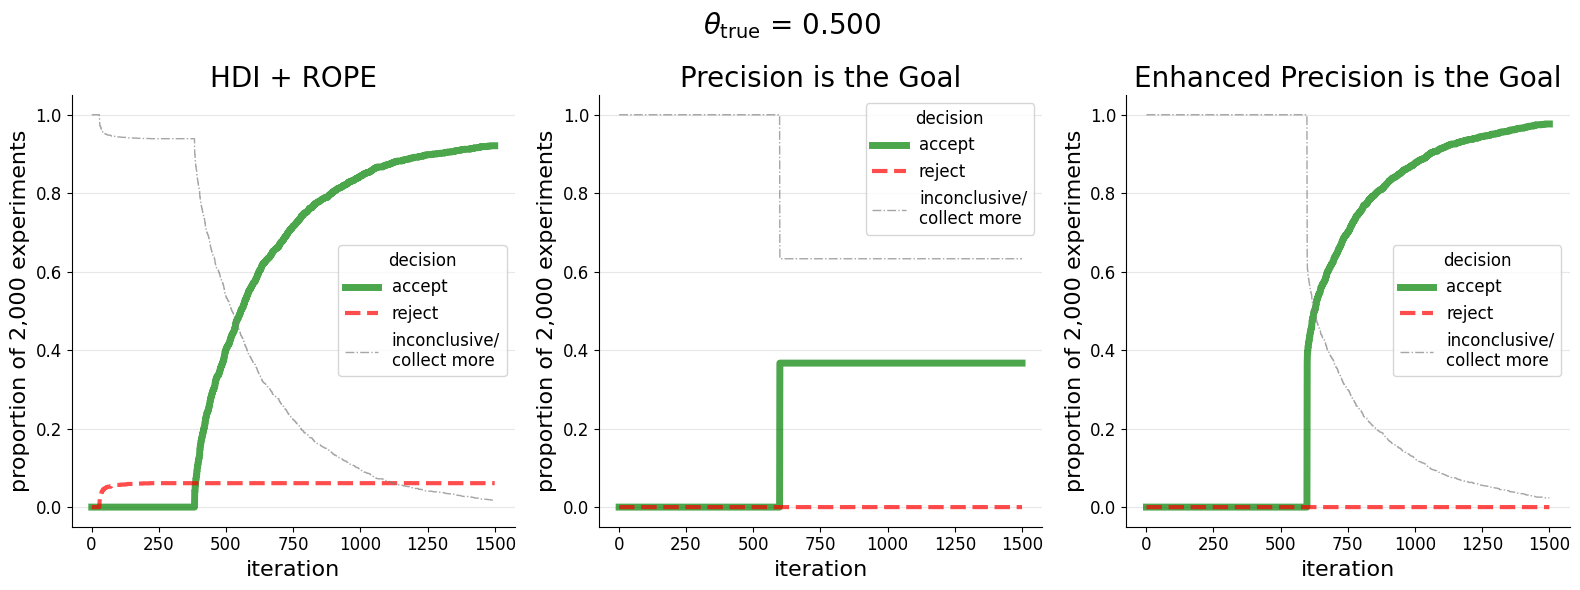

In [15]:
hypothesis_0pt5.plot_decision_rates(synth_0pt5.success_rate, viz_epitg="separate")
#plt.savefig("../latex/images/fair_experiment_decision_rates.png")

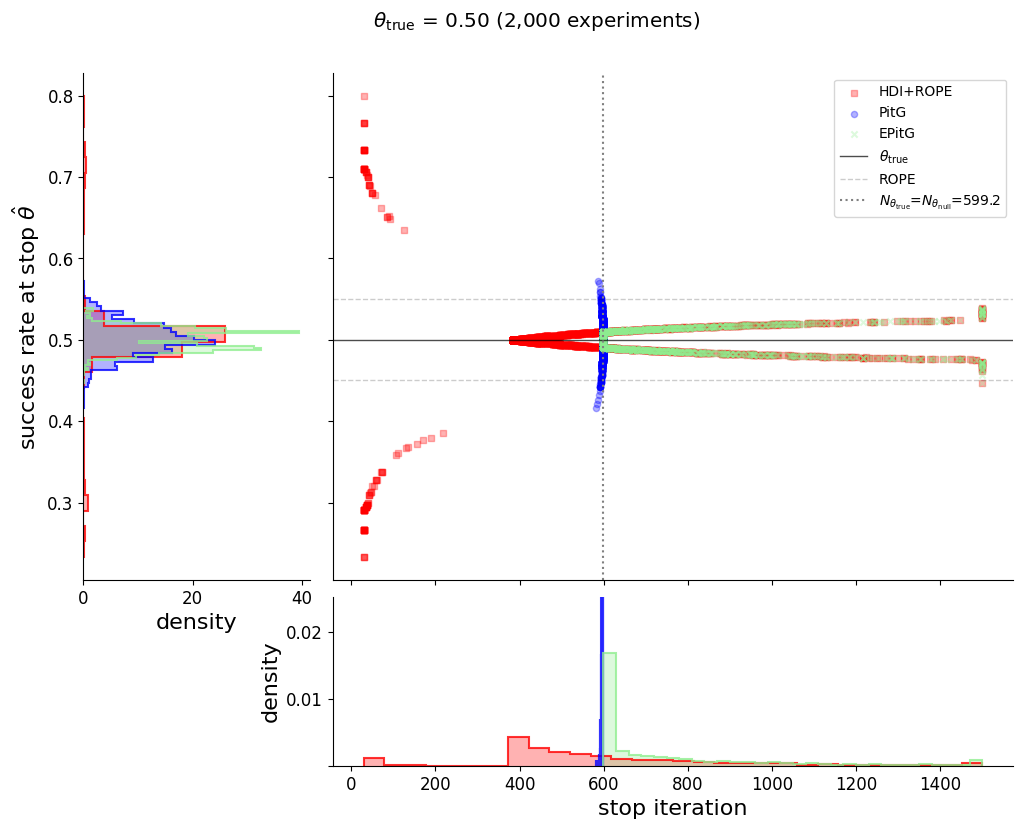

In [16]:
hypothesis_0pt5.plot_stop_iter_sample_rates(success_rate=synth_0pt5.success_rate, title=None)
#plt.savefig("../latex/images/fair_experiments_iter_vs_rate.png")

In [109]:
627./ 599

1.0467445742904842

In [17]:
# Summary Stats
df_stats_0pt5 = report_success_rates_multiple_algos(hypothesis_0pt5.method_df_stats.copy())

count  param_frac  param_mean  param_std  param_p25  \
algorithm group                                                               
pitg      overall        2000      1.0000    0.499978   0.020554   0.485810   
          conclusive      734      0.3670    0.500293   0.005508   0.495826   
          inconclusive   1266      0.6330    0.499794   0.025494   0.479933   
          accept          734      0.3670    0.500293   0.005508   0.495826   
epitg     overall        2000      1.0000    0.500032   0.013120   0.489465   
          conclusive     1953      0.9765    0.499973   0.012220   0.489499   
          inconclusive     47      0.0235    0.502454   0.033731   0.470000   
          accept         1953      0.9765    0.499973   0.012220   0.489499   
hdi_rope  overall        2000      1.0000    0.498253   0.051782   0.491803   
          conclusive     1964      0.9820    0.498114   0.052057   0.491892   
          inconclusive     36      0.0180    0.505870   0.033090   0.471333   
          accept         1842      0.9210    0.499911   0.010597   0.492620   
          reject          122      0.0610    0.470976   0.203625   0.294118   

                        param_median  param_p75  stop_iter_mean  \
algorithm group                                                   
pitg      overall           0.500835   0.514190      598.209000   
          conclusive        0.500835   0.504174      599.000000   
          inconclusive      0.489149   0.520067      597.750395   
          accept            0.500835   0.504174      599.000000   
epitg     overall           0.500835   0.510501      740.966500   
          conclusive        0.500835   0.510433      722.699949   
          inconclusive      0.526667   0.533667     1500.000000   
          accept            0.500835   0.510433      722.699949   
hdi_rope  overall           0.500000   0.508057      592.983500   
          conclusive        0.500000   0.507519      576.357943   
          inconclusive      0.528000   0.533500     1500.000000   
          accept            0.500000   0.507435      611.389794   
          reject            0.337838   0.702027       47.434426   

                        stop_iter_std  stop_iter_p25  stop_iter_median  \
algorithm group                                                          
pitg      overall            1.457526          598.0             599.0   
          conclusive         0.000000          599.0             599.0   
          inconclusive       1.668382          597.0             598.0   
          accept             0.000000          599.0             599.0   
epitg     overall          221.187573          599.0             627.0   
          conclusive       189.462560          599.0             623.0   
          inconclusive       0.000000         1500.0            1500.0   
          accept           189.462560          599.0             623.0   
hdi_rope  overall          290.737790          415.0             523.0   
          conclusive       265.922483          413.0             519.0   
          inconclusive       0.000000         1500.0            1500.0   
          accept           235.712841          426.5             536.0   
          reject            33.382083           31.0              34.0   

                        stop_iter_p75  conclusive_mean  accept_mean  \
algorithm group                                                       
pitg      overall              599.00           0.3670     0.367000   
          conclusive           599.00           1.0000     1.000000   
          inconclusive         599.00           0.0000     0.000000   
          accept               599.00           1.0000     1.000000   
epitg     overall              794.00           0.9765     0.976500   
          conclusive           775.00           1.0000     1.000000   
          inconclusive        1500.00           0.0000     0.000000   
          accept               775.00           1.0000     1.000000   
hdi_rope  o

In [68]:
hypothesis_0pt5.decision_correctness(fair_coin_rate)

hypothesis_0pt5.df_experiment_correctness.head(4)

updated!


,hdi_rope_decision_iteration,hdi_rope_accept,hdi_rope_reject_below,hdi_rope_reject_above,hdi_rope_inconclusive,hdi_rope_param_value,hdi_rope_decision_correct,pitg_decision_iteration,pitg_accept,pitg_reject_below,...,pitg_inconclusive,pitg_param_value,pitg_decision_correct,epitg_decision_iteration,epitg_accept,epitg_reject_below,epitg_reject_above,epitg_inconclusive,epitg_param_value,epitg_decision_correct
experiment_idx,,,,,,,,,,,,,,,,,,,,,
0,640,True,False,False,False,0.510938,True,598,False,False,...,True,0.521739,True,640,True,False,False,False,0.510938,True
1,502,True,False,False,False,0.505976,True,599,True,False,...,False,0.505843,True,599,True,False,False,False,0.505843,True
2,398,True,False,False,False,0.5,True,599,True,False,...,False,0.504174,True,599,True,False,False,False,0.504174,True
3,496,True,False,False,False,0.493952,True,599,True,False,...,False,0.492487,True,599,True,False,False,False,0.492487,True


In [19]:
hypothesis_0pt5.decision_correctness(fair_coin_rate)

hypothesis_0pt5.df_experiment_correctness.head(4)

,hdi_rope_decision_iteration,hdi_rope_accept,hdi_rope_reject_below,hdi_rope_reject_above,hdi_rope_inconclusive,hdi_rope_success_rate,hdi_rope_decision_correct,pitg_decision_iteration,pitg_accept,pitg_reject_below,...,pitg_inconclusive,pitg_success_rate,pitg_decision_correct,epitg_decision_iteration,epitg_accept,epitg_reject_below,epitg_reject_above,epitg_inconclusive,epitg_success_rate,epitg_decision_correct
experiment_idx,,,,,,,,,,,,,,,,,,,,,
0,640,True,False,False,False,0.510938,True,598,False,False,...,True,0.521739,True,640,True,False,False,False,0.510938,True
1,502,True,False,False,False,0.505976,True,599,True,False,...,False,0.505843,True,599,True,False,False,False,0.505843,True
2,398,True,False,False,False,0.5,True,599,True,False,...,False,0.504174,True,599,True,False,False,False,0.504174,True
3,496,True,False,False,False,0.493952,True,599,True,False,...,False,0.492487,True,599,True,False,False,False,0.492487,True


In [20]:
# TODO: move to shared

def correctness_stats(df_experiment_correctness):
    q_pitg_inc = "pitg_inconclusive == True"
    cols_inconclusive = ['hdi_rope_inconclusive', 'pitg_inconclusive', 'epitg_inconclusive']
    cols_correctness = ['hdi_rope_decision_correct', 'pitg_decision_correct', 'epitg_decision_correct']

    return {
        "inconclusive_rates": df_experiment_correctness[cols_inconclusive].astype(int).mean(),
        "correctness_rates": df_experiment_correctness[cols_correctness].astype(int).mean(),
        "correctness_rates_pitg_inconclusive": df_experiment_correctness.query(q_pitg_inc)[cols_correctness].astype(int).mean()
    }

correctness_stats(hypothesis_0pt5.df_experiment_correctness)

{'inconclusive_rates': hdi_rope_inconclusive    0.0180
 pitg_inconclusive        0.6330
 epitg_inconclusive       0.0235
 dtype: float64,
 'correctness_rates': hdi_rope_decision_correct    0.9385
 pitg_decision_correct        0.9850
 epitg_decision_correct       0.9995
 dtype: float64,
 'correctness_rates_pitg_inconclusive': hdi_rope_decision_correct    0.927330
 pitg_decision_correct        0.976303
 epitg_decision_correct       0.999210
 dtype: float64}

In [21]:
# experiment ids for which:
# - HDI_ROPE method had success rate > 0.55
# - PITG method was inconclusive
# - EPITG method was conclusive

experiment_idxs = list(sorted(set(hypothesis_0pt5.method_df_stats["pitg"].query("inconclusive").index) &\
set(hypothesis_0pt5.method_df_stats["epitg"].query("accept").index) &\
set(hypothesis_0pt5.method_df_stats["hdi_rope"].query("success_rate > 0.55").index)))
len(experiment_idxs)

35

1011010001100100001011111111100101011011100011111100101001101111111101110011110011100111100010100010111101011111100011111111111000001010010011000000011010001000100000000100101110011101001110000100101100110100001010111100111111110111001010110111001001010100111101010011110111001011100100110010100100010010110101010101001111001100110110111011100101000101100110011001011110011111011101010100011011101111000101101010101010101111000010001110110010101011001001100100011011011111001110000100110010000010101100101011010000011001010001101011100101011010001001101001001001101101001010111000011010001111110010011111001000111000110001010010101011100100001101111011110111001110110100100010010011110111001000001000111000000100101111110111101010001101100100011001010111100000010011011111000000010100110010011100010101000001011111001011100110110101110010000111100100111111100111111111001110110100001011101100011001110010000100111011001110001100101000000011011100001100111001110111001010011010100110010101000110000000

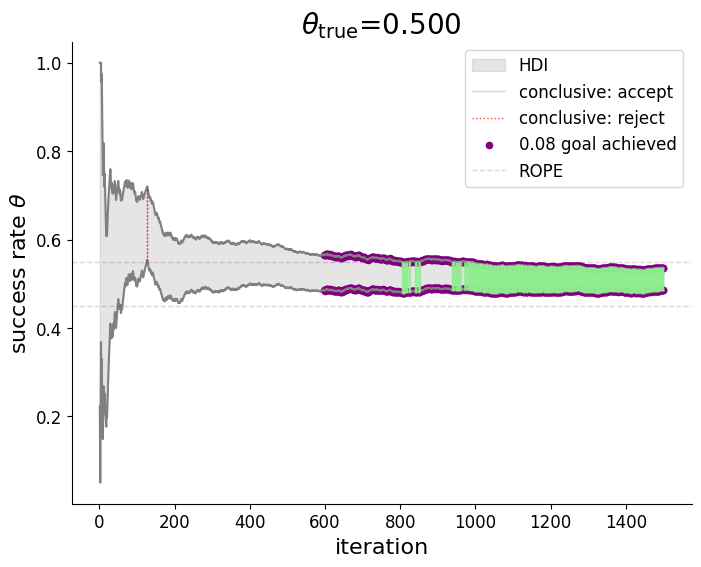

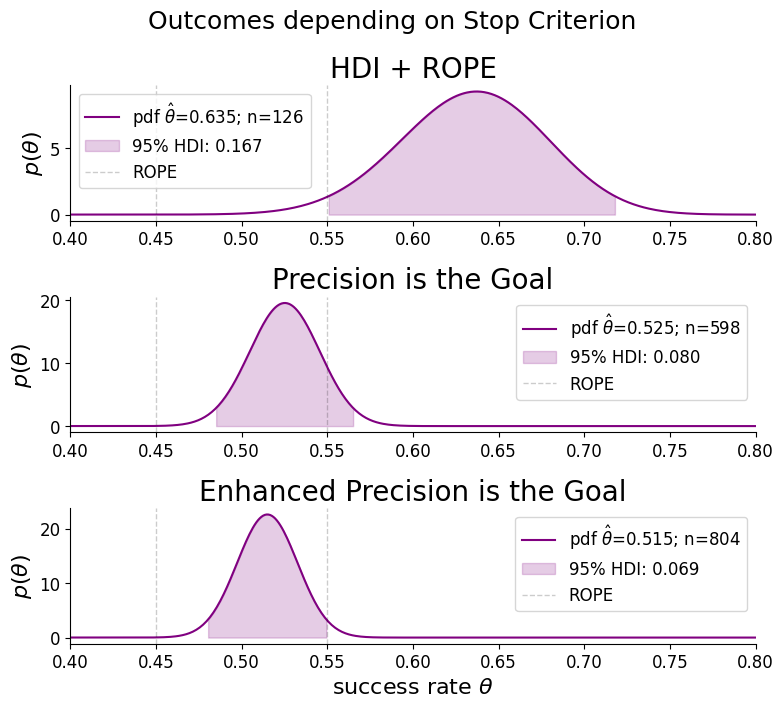

In [22]:
# Visualising outcomes of one experiment

#iexperiment = experiment_idxs[0]
#iexperiment = experiment_idxs[1]  # good example
iexperiment = experiment_idxs[2]  # good example. USE THIS ONE!

# for viz
method_names = ["hdi_rope", "pitg", "epitg"]

print("".join([f"{b_}" for b_ in hypothesis_0pt5.experiments[iexperiment,:] ]))

xlim = (0.4, 0.8)
df_experiment_results = hypothesis_0pt5.one_experiment_all_iterations(iexperiment, binary_accounting=binary_accounting, viz=True, success_rate=synth_0pt5.success_rate, method_names=method_names, xlim=xlim)

#plt.savefig('../latex/foo.png')

## Loaded Coin $\theta_{\rm true}=0.6$

In [69]:
sims_hypo0pt5_results = {
    0.50: {
        "synth": synth_0pt5,
        "hypothesis": hypothesis_0pt5,
        "df_stats": df_stats_0pt5.copy()
    }
}

Generating synthetic data with parameter values:
0.6: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,0.9920,0.9920,0.0080,278.5250,296.550922,0.642112,0.056068
pitg,0.0,0.6930,0.6930,0.3070,574.0995,10.032693,0.600358,0.020512
epitg,0.0,0.9905,0.9905,0.0095,638.4050,164.652043,0.602890,0.017084


viz_epitg separate


count  param_frac  param_mean  param_std  param_p25  \
algorithm group                                                               
pitg      overall        2000      1.0000    0.600358   0.020512   0.586919   
          conclusive     1386      0.6930    0.610716   0.014524   0.598958   
          inconclusive    614      0.3070    0.576978   0.010264   0.570698   
          reject         1386      0.6930    0.610716   0.014524   0.598958   
epitg     overall        2000      1.0000    0.602890   0.017084   0.589491   
          conclusive     1981      0.9905    0.603219   0.016824   0.589615   
          inconclusive     19      0.0095    0.568596   0.005052   0.567333   
          reject         1981      0.9905    0.603219   0.016824   0.589615   
hdi_rope  overall        2000      1.0000    0.642112   0.056068   0.598485   
          conclusive     1984      0.9920    0.642695   0.055915   0.598972   
          inconclusive     16      0.0080    0.569833   0.002727   0.568500   
          reject         1984      0.9920    0.642695   0.055915   0.598972   

                        param_median  param_p75  stop_iter_mean  \
algorithm group                                                   
pitg      overall           0.600000   0.614437      574.099500   
          conclusive        0.607706   0.619469      569.360029   
          inconclusive      0.578767   0.584192      584.798046   
          reject            0.607706   0.619469      569.360029   
epitg     overall           0.600000   0.614437      638.405000   
          conclusive        0.600000   0.614437      630.141343   
          inconclusive      0.570000   0.571000     1500.000000   
          reject            0.600000   0.614437      630.141343   
hdi_rope  overall           0.624242   0.680000      278.525000   
          conclusive        0.624277   0.680000      268.674395   
          inconclusive      0.570333   0.571333     1500.000000   
          reject            0.624277   0.680000      268.674395   

                        stop_iter_std  stop_iter_p25  stop_iter_median  \
algorithm group                                                          
pitg      overall           10.032693          568.0             575.0   
          conclusive         8.148768          565.0             571.0   
          inconclusive       3.574186          582.0             584.0   
          reject             8.148768          565.0             571.0   
epitg     overall          164.652043          568.0             575.0   
          conclusive       142.051400          568.0             575.0   
          inconclusive       0.000000         1500.0            1500.0   
          reject           142.051400          568.0             575.0   
hdi_rope  overall          296.550922           50.0             168.0   
          conclusive       276.616344           50.0             165.0   
          inconclusive       0.000000         1500.0            1500.0   
          reject           276.616344           50.0             165.0   

                        stop_iter_p75  conclusive_mean  accept_mean  \
algorithm group                                                       
pitg      overall               581.0           0.6930          0.0   
          conclusive            576.0           1.0000          0.0   
          inconclusive          587.0           0.0000          0.0   
          reject                576.0           1.0000          0.0   
epitg     overall               607.0           0.9905          0.0   
          conclusive            602.0           1.0000          0.0   
          inconclusive         1500.0           0.0000          0.0   
          reject                602.0           1.0000          0.0   
hdi_rope  overall               401.5           0.9920          0.0   
          conclusive            394.5           1.0000          0.0   
          inconclusive         1500.0           0.0000          0.0   
          reject  

CPU times: user 5.29 s, sys: 234 ms, total: 5.53 s
Wall time: 5.44 s


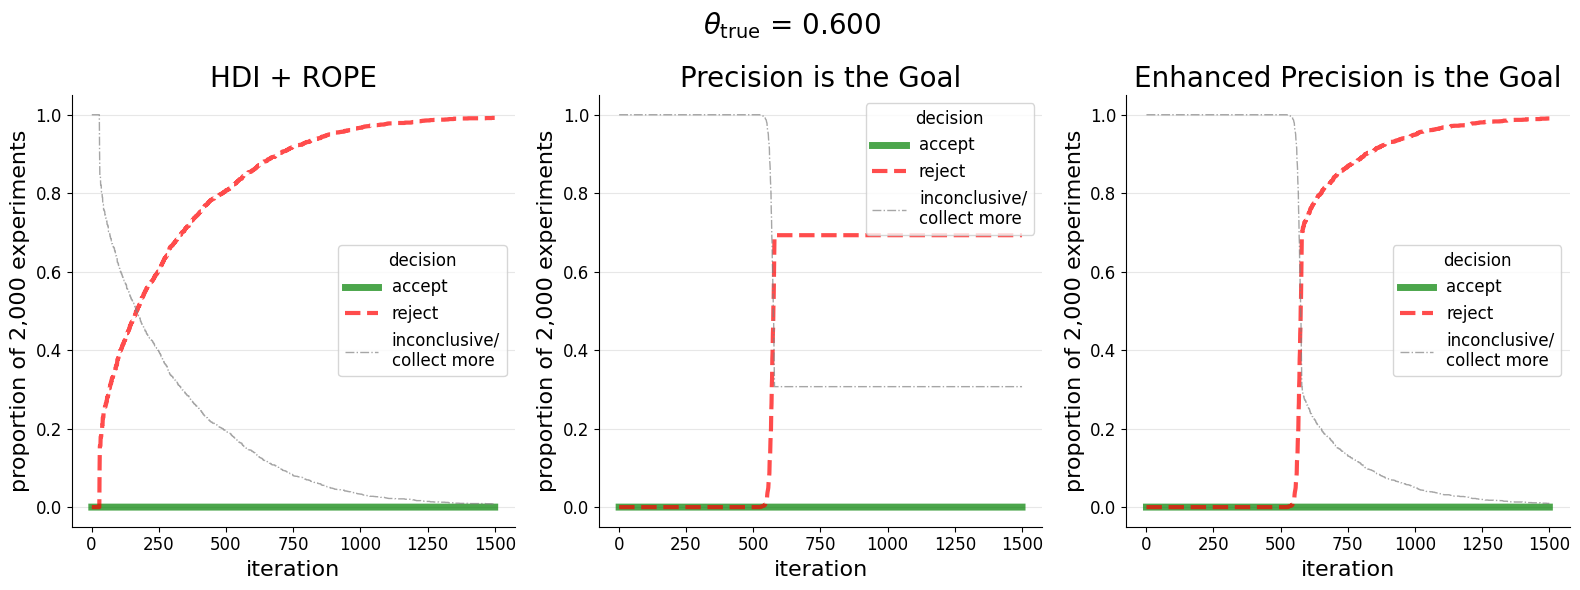

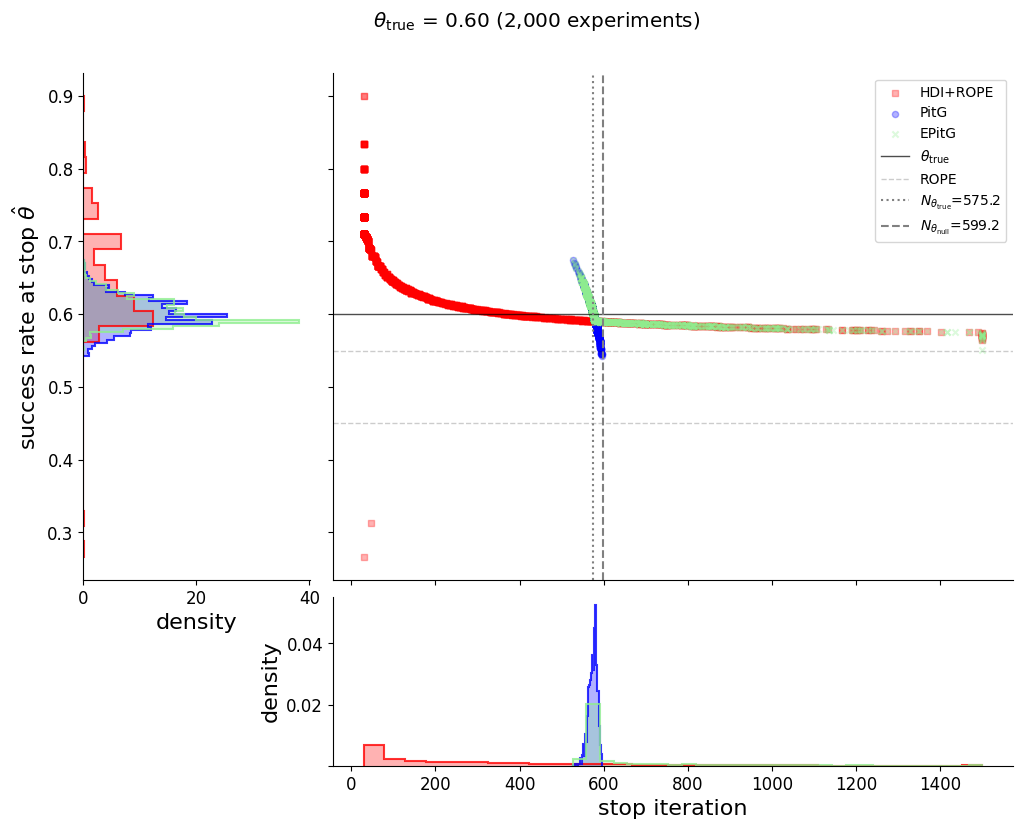

In [70]:
%%time

loaded_0pt6_rate = 0.60

sims_hypo0pt5_results[0.60] = run_simulations_and_analysis_report(
    binary_accounting,
    success_rate_true=loaded_0pt6_rate,
    success_rate_null=null_rate_fair,
    dsuccess_rate=dsuccess_rate,
    n_experiments=N_EXPERIMENTS,
    n_samples=N_SAMPLES,
    rope_precision_fraction=rope_precision_fraction,
    seed=SEED,
    viz=True
)

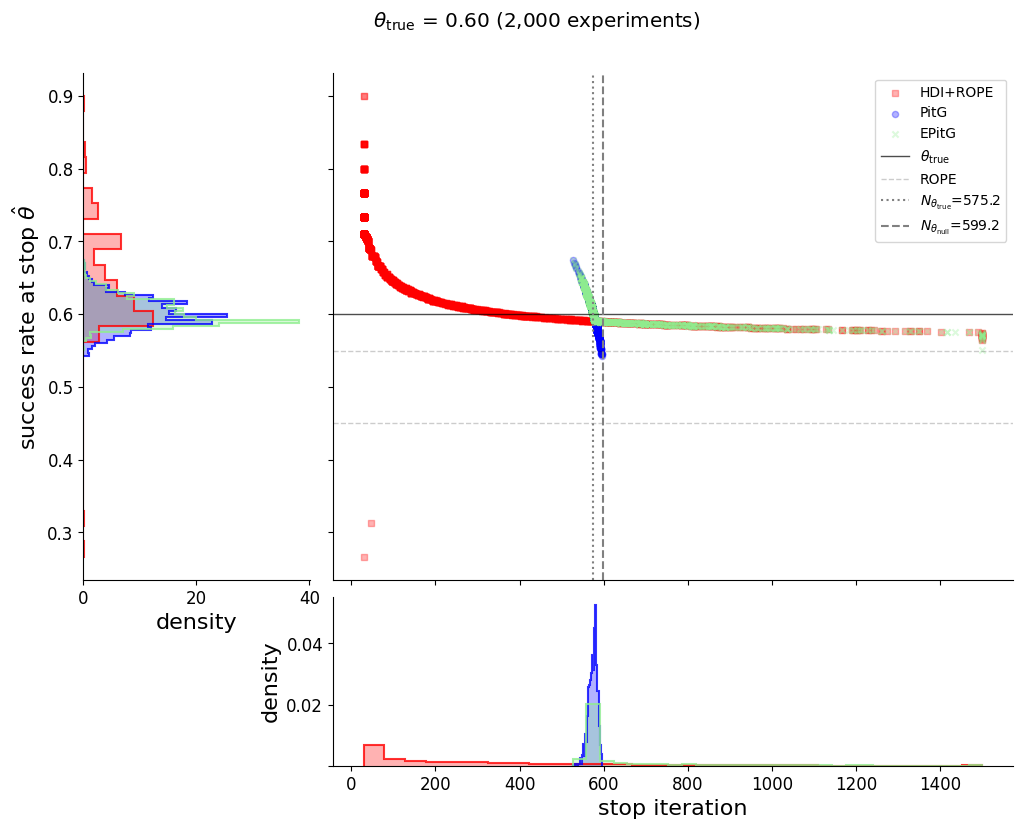

In [71]:
sims_hypo0pt5_results[0.60]['hypothesis'].plot_stop_iter_sample_rates(success_rate=sims_hypo0pt5_results[0.60]['synth'].success_rate, title=None)

#plt.savefig("../latex/images/loaded0pt6_experiments_iter_vs_rate.png")

viz_epitg separate


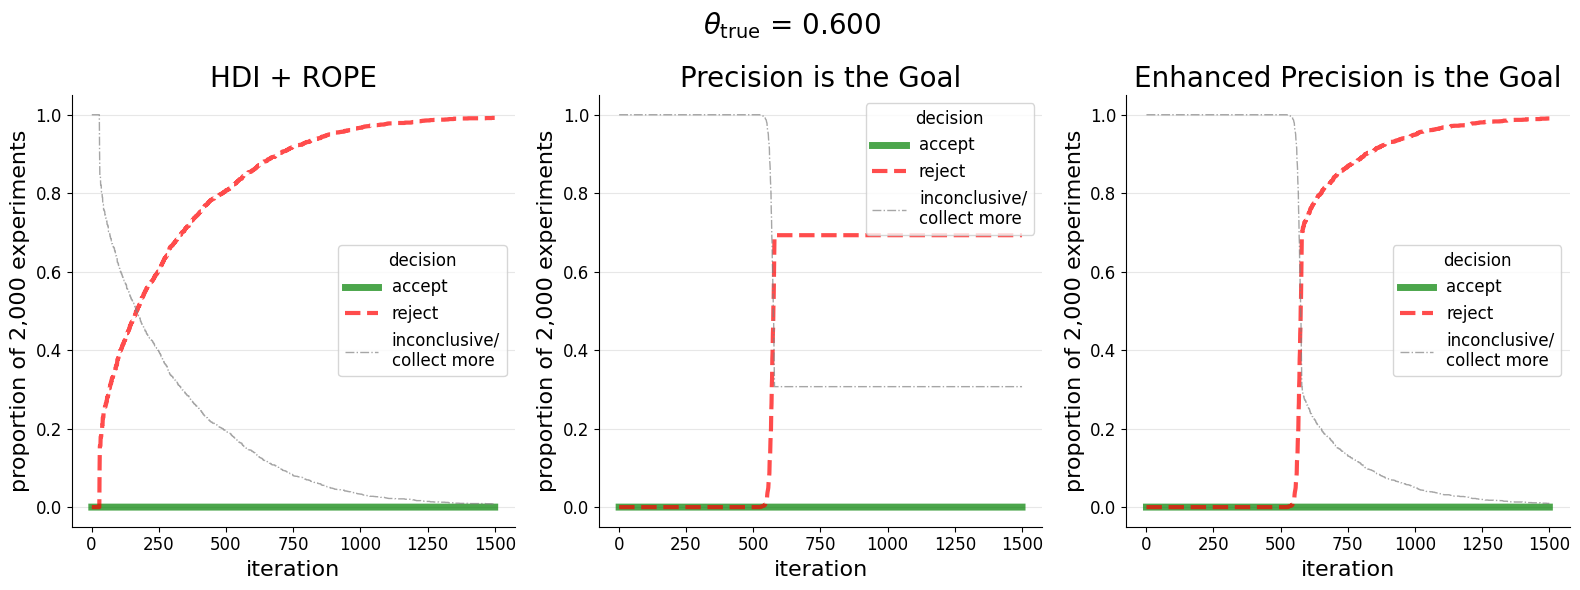

In [72]:
sims_hypo0pt5_results[0.60]['hypothesis'].plot_decision_rates(sims_hypo0pt5_results[0.60]['synth'].success_rate, viz_epitg="separate")
#plt.savefig("../latex/images/loaded0pt6_experiment_decision_rates.png")

In [73]:
report_accounting_size(binary_accounting)

Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 93 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits



In [74]:
correctness_stats(sims_hypo0pt5_results[0.60]['hypothesis'].df_experiment_correctness)

{'inconclusive_rates': hdi_rope_inconclusive    0.0080
 pitg_inconclusive        0.3070
 epitg_inconclusive       0.0095
 dtype: float64,
 'correctness_rates': hdi_rope_decision_correct    1.0000
 pitg_decision_correct        0.9945
 epitg_decision_correct       1.0000
 dtype: float64,
 'correctness_rates_pitg_inconclusive': hdi_rope_decision_correct    1.000000
 pitg_decision_correct        0.982085
 epitg_decision_correct       1.000000
 dtype: float64}

# Running Multiple Coins

In [75]:
%%time

loaded_coin_rates = [0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65]

for this_rate in loaded_coin_rates:
    sims_hypo0pt5_results[this_rate] = run_simulations_and_analysis_report(
        binary_accounting,
        success_rate_true=this_rate,
        success_rate_null=null_rate_fair,
        dsuccess_rate=dsuccess_rate,
        n_experiments=N_EXPERIMENTS,
        n_samples=N_SAMPLES,
        rope_precision_fraction=rope_precision_fraction,
        seed=SEED,
        viz=False
    )

    report_accounting_size(binary_accounting)
    print("-" * 40)

Generating synthetic data with parameter values:
0.51: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.877,0.0715,0.9485,0.0515,640.6875,349.645620,0.511196,0.053880
pitg,0.335,0.0005,0.3355,0.6645,597.9670,1.774115,0.510097,0.020574
epitg,0.932,0.0005,0.9325,0.0675,798.5955,277.257149,0.507063,0.013793


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 99 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.52: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.7420,0.0780,0.820,0.180,781.3675,454.818403,0.521762,0.054782
pitg,0.2345,0.0015,0.236,0.764,597.2440,2.499317,0.520183,0.020711
epitg,0.7780,0.0020,0.780,0.220,946.1260,364.507324,0.515122,0.015324


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 121 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.53: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.5110,0.1140,0.625,0.375,942.3635,532.153087,0.536867,0.059220
pitg,0.1445,0.0025,0.147,0.853,596.0795,3.341371,0.530125,0.020632
epitg,0.5310,0.0060,0.537,0.463,1148.5125,385.163010,0.525122,0.017286


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 152 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.54: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.2670,0.1625,0.4295,0.5705,1070.8565,559.737505,0.553041,0.060163
pitg,0.0675,0.0085,0.0760,0.9240,594.4305,4.218420,0.540124,0.020426
epitg,0.2600,0.0305,0.2905,0.7095,1308.2205,334.458018,0.537258,0.018572


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 179 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.55: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.110,0.2540,0.3640,0.6360,1090.1835,588.159585,0.570888,0.060070
pitg,0.022,0.0270,0.0490,0.9510,592.2885,5.208439,0.550080,0.020389
epitg,0.094,0.0925,0.1865,0.8135,1373.9355,286.618554,0.550075,0.018580


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 184 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.56: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0330,0.4150,0.448,0.552,998.4935,618.529451,0.588080,0.059521
pitg,0.0035,0.0725,0.076,0.924,589.5750,6.138340,0.560317,0.020270
epitg,0.0215,0.2685,0.290,0.710,1303.4305,341.767516,0.563398,0.018307


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.57: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0080,0.6480,0.6560,0.3440,804.6165,611.021115,0.604697,0.058295
pitg,0.0005,0.1570,0.1575,0.8425,586.4470,7.116144,0.570288,0.020308
epitg,0.0035,0.5415,0.5450,0.4550,1127.1755,395.941462,0.575583,0.017217


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.58: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0005,0.8530,0.8535,0.1465,585.331,540.685760,0.620141,0.057135
pitg,0.0000,0.3175,0.3175,0.6825,582.768,8.108641,0.580360,0.020475
epitg,0.0000,0.8045,0.8045,0.1955,914.951,372.452422,0.586007,0.015814


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.59: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,0.9695,0.9695,0.0305,394.8700,406.259818,0.632173,0.056758
pitg,0.0,0.5045,0.5045,0.4955,578.6600,9.058942,0.590418,0.020469
epitg,0.0,0.9570,0.9570,0.0430,735.8265,266.307359,0.594787,0.015723


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.6: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,0.9920,0.9920,0.0080,278.5250,296.550922,0.642112,0.056068
pitg,0.0,0.6930,0.6930,0.3070,574.0995,10.032693,0.600358,0.020512
epitg,0.0,0.9905,0.9905,0.0095,638.4050,164.652043,0.602890,0.017084


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.61: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,0.9995,0.9995,0.0005,204.231,214.909825,0.651210,0.055878
pitg,0.0,0.8410,0.8410,0.1590,569.074,11.120493,0.610348,0.020662
epitg,0.0,0.9985,0.9985,0.0015,592.493,92.655396,0.611506,0.018766


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.62: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.000,1.000,0.000,157.7065,161.762505,0.659565,0.055200
pitg,0.0,0.934,0.934,0.066,563.4645,12.119744,0.620420,0.020708
epitg,0.0,1.000,1.000,0.000,571.4140,51.754361,0.620869,0.019815


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.63: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.000,1.000,0.000,122.6660,122.368867,0.668872,0.055158
pitg,0.0,0.974,0.974,0.026,557.3740,13.044585,0.630577,0.020629
epitg,0.0,1.000,1.000,0.000,559.7985,28.474784,0.630724,0.020284


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.64: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.000,1.000,0.000,99.2070,91.864927,0.677392,0.054354
pitg,0.0,0.992,0.992,0.008,550.8565,14.155038,0.640579,0.020743
epitg,0.0,1.000,1.000,0.000,551.3665,17.474663,0.640609,0.020664


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.65: true success rate
2000: experiments
1500: sample size per experiment
0.5: null hypothesis
0.45: ROPE min
0.55: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.0000,1.0000,0.0000,82.5675,72.153569,0.686040,0.055239
pitg,0.0,0.9995,0.9995,0.0005,543.6420,15.324466,0.650811,0.020900
epitg,0.0,1.0000,1.0000,0.0000,543.6445,15.330970,0.650812,0.020898


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
CPU times: user 1min 30s, sys: 617 ms, total: 1min 31s
Wall time: 1min 32s


In [ ]:
algo_stats_df = sims_hypo_dict_to_algo_stats_dfs(sims_hypo0pt5_results)

algo_stats_df['overall']['epitg']

stat,count,stop_iter_p25,stop_iter_median,stop_iter_p75,stop_iter_mean,param_mean,param_p25,param_median,param_p75,conclusive_mean,accept_mean,reject_mean
theta_true,,,,,,,,,,,,
0.50,2000.0,599.00,627.0,794.00,740.9665,0.500032,0.489465,0.500835,0.510501,0.9765,0.9765,0.0000
0.51,2000.0,599.00,661.0,896.25,798.5955,0.507063,0.495826,0.509740,0.516279,0.9325,0.9320,0.0005
0.52,2000.0,600.00,792.0,1363.25,946.1260,0.515122,0.505843,0.514687,0.523366,0.7800,0.7780,0.0020
0.53,2000.0,697.75,1376.5,1500.00,1148.5125,0.525122,0.512482,0.523639,0.538000,0.5370,0.5310,0.0060
0.54,2000.0,1224.75,1500.0,1500.00,1308.2205,0.537258,0.524072,0.540000,0.548000,0.2905,0.2600,0.0305
0.55,2000.0,1500.00,1500.0,1500.00,1373.9355,0.550075,0.541333,0.550000,0.558667,0.1865,0.0940,0.0925
0.56,2000.0,1217.25,1500.0,1500.00,1303.4305,0.563398,0.551333,0.560667,0.576497,0.2900,0.0215,0.2685
0.57,2000.0,667.00,1311.0,1500.00,1127.1755,0.575583,0.562000,0.576765,0.587613,0.5450,0.0035,0.5415
0.58,2000.0,578.00,743.0,1291.50,914.9510,0.586007,0.577072,0.585561,0.593426,0.8045,0.0000,0.8045


In [ ]:
# algo_stats_df = {}

# # subset_name = "overall"
# # #subset_name = "conclusive"

# l_stats_viz = ["count","stop_iter_p25", 'stop_iter_median', "stop_iter_p75", "stop_iter_mean",
# "param_mean", "param_p25", "param_median", "param_p75",
# "conclusive_mean", "accept_mean", "reject_mean"]

# for subset_name in ["overall", "conclusive", "inconclusive"]:
#     algo_stats_df[subset_name] = {}
#     for algo_name in [ 'hdi_rope','pitg', 'epitg']:
#         result_summary = {}
#         for theta_true, experiment_result in sims_hypo0pt5_results.items():
#             if (algo_name, subset_name) in experiment_result['df_stats'].index:
#                 result_summary[theta_true] = experiment_result['df_stats'].loc[(algo_name, subset_name), l_stats_viz]
#             else:
#                 result_summary[theta_true] = pd.Series({metric_:None for metric_ in l_stats_viz})
#                 result_summary[theta_true]["count"] = 0


#         algo_stats_df[subset_name][algo_name] = pd.DataFrame(result_summary)
#         algo_stats_df[subset_name][algo_name].columns.name = 'theta_true'
#         algo_stats_df[subset_name][algo_name].index.name = 'stat'
#         algo_stats_df[subset_name][algo_name] = algo_stats_df[subset_name][algo_name].T

#         algo_stats_df[subset_name][algo_name]  = algo_stats_df[subset_name][algo_name].sort_index()

# print(subset_name)
# algo_stats_df[subset_name][algo_name]

stat,count,stop_iter_p25,stop_iter_median,stop_iter_p75,stop_iter_mean,param_mean,param_p25,param_median,param_p75,conclusive_mean,accept_mean,reject_mean
theta_true,,,,,,,,,,,,
0.50,47.0,1500.0,1500.0,1500.0,1500.0,0.502454,0.47,0.526667,0.533667,0.0,0.0,0.0
0.51,135.0,1500.0,1500.0,1500.0,1500.0,0.533111,0.529333,0.532667,0.537333,0.0,0.0,0.0
0.52,440.0,1500.0,1500.0,1500.0,1500.0,0.535841,0.530667,0.534667,0.54,0.0,0.0,0.0
0.53,926.0,1500.0,1500.0,1500.0,1500.0,0.539618,0.5335,0.538667,0.544667,0.0,0.0,0.0
0.54,1419.0,1500.0,1500.0,1500.0,1500.0,0.544114,0.537333,0.543333,0.55,0.0,0.0,0.0
0.55,1627.0,1500.0,1500.0,1500.0,1500.0,0.549961,0.542667,0.55,0.556667,0.0,0.0,0.0
0.56,1420.0,1500.0,1500.0,1500.0,1500.0,0.555794,0.55,0.556667,0.562667,0.0,0.0,0.0
0.57,910.0,1500.0,1500.0,1500.0,1500.0,0.560624,0.556,0.561333,0.566667,0.0,0.0,0.0
0.58,391.0,1500.0,1500.0,1500.0,1500.0,0.564246,0.560667,0.565333,0.569333,0.0,0.0,0.0


In [82]:
algo_stats_df['overall'][algo_name]

stat,count,stop_iter_p25,stop_iter_median,stop_iter_p75,stop_iter_mean,param_mean,param_p25,param_median,param_p75,conclusive_mean,accept_mean,reject_mean
theta_true,,,,,,,,,,,,
0.50,2000.0,599.00,627.0,794.00,740.9665,0.500032,0.489465,0.500835,0.510501,0.9765,0.9765,0.0000
0.51,2000.0,599.00,661.0,896.25,798.5955,0.507063,0.495826,0.509740,0.516279,0.9325,0.9320,0.0005
0.52,2000.0,600.00,792.0,1363.25,946.1260,0.515122,0.505843,0.514687,0.523366,0.7800,0.7780,0.0020
0.53,2000.0,697.75,1376.5,1500.00,1148.5125,0.525122,0.512482,0.523639,0.538000,0.5370,0.5310,0.0060
0.54,2000.0,1224.75,1500.0,1500.00,1308.2205,0.537258,0.524072,0.540000,0.548000,0.2905,0.2600,0.0305
0.55,2000.0,1500.00,1500.0,1500.00,1373.9355,0.550075,0.541333,0.550000,0.558667,0.1865,0.0940,0.0925
0.56,2000.0,1217.25,1500.0,1500.00,1303.4305,0.563398,0.551333,0.560667,0.576497,0.2900,0.0215,0.2685
0.57,2000.0,667.00,1311.0,1500.00,1127.1755,0.575583,0.562000,0.576765,0.587613,0.5450,0.0035,0.5415
0.58,2000.0,578.00,743.0,1291.50,914.9510,0.586007,0.577072,0.585561,0.593426,0.8045,0.0000,0.8045


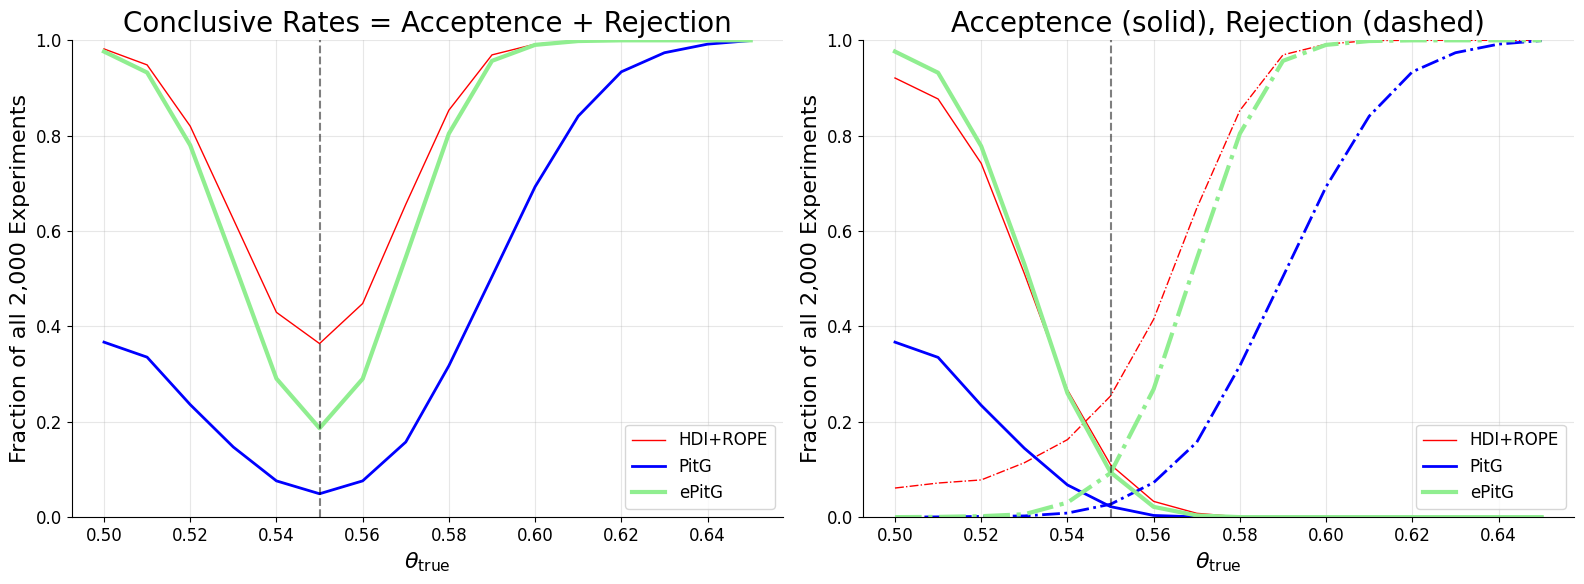

In [ ]:
# Moved below to include correctness rates
# ALGO_NAME = {"hdi_rope":"HDI+ROPE", "pitg": "PitG", "epitg": "ePitG"}
# ALGO_LINEWIDTH =  {"hdi_rope":1, "pitg": 2, "epitg":3}

# subset_name = "overall"

# plt.figure(figsize=(2 * FIG_WIDTH, FIG_HEIGHT))

# # Conclusive Rates
# plt.subplot(1, 2, 1)
# for algo_name in ALGO_NAME:
#     plt.plot(algo_stats_df[subset_name][algo_name]["conclusive_mean"],
#     color=ALGO_COLORS[algo_name], label=ALGO_NAME[algo_name], linewidth=ALGO_LINEWIDTH[algo_name])

# plt.grid(alpha=0.3)
# plt.xlabel(r"$\theta_{\rm true}$")
# plt.legend()
# plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

# plt.title("Conclusive Rates = Acceptence + Rejection")
# plt.ylabel(f"Fraction of all {N_EXPERIMENTS:,} Experiments")

# plt.ylim(0.,1)

# # Acceptence + Rejection Rates
# plt.subplot(1, 2, 2)
# for algo_name in ALGO_NAME:
#     plt.plot(algo_stats_df[subset_name][algo_name]["accept_mean"],
#     color=ALGO_COLORS[algo_name], label=ALGO_NAME[algo_name], linewidth=ALGO_LINEWIDTH[algo_name])

#     plt.plot(algo_stats_df[subset_name][algo_name]["reject_mean"],
#         color=ALGO_COLORS[algo_name], linewidth=ALGO_LINEWIDTH[algo_name], linestyle="-.")

# plt.grid(alpha=0.3)
# plt.xlabel(r"$\theta_{\rm true}$")
# plt.ylabel(f"Fraction of all {N_EXPERIMENTS:,} Experiments")
# plt.title("Acceptence (solid), Rejection (dashed)")
# plt.legend()
# plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

# plt.ylim(0.,1)

# plt.tight_layout()
# plt.savefig('../latex/images/conclusive_rates.png')

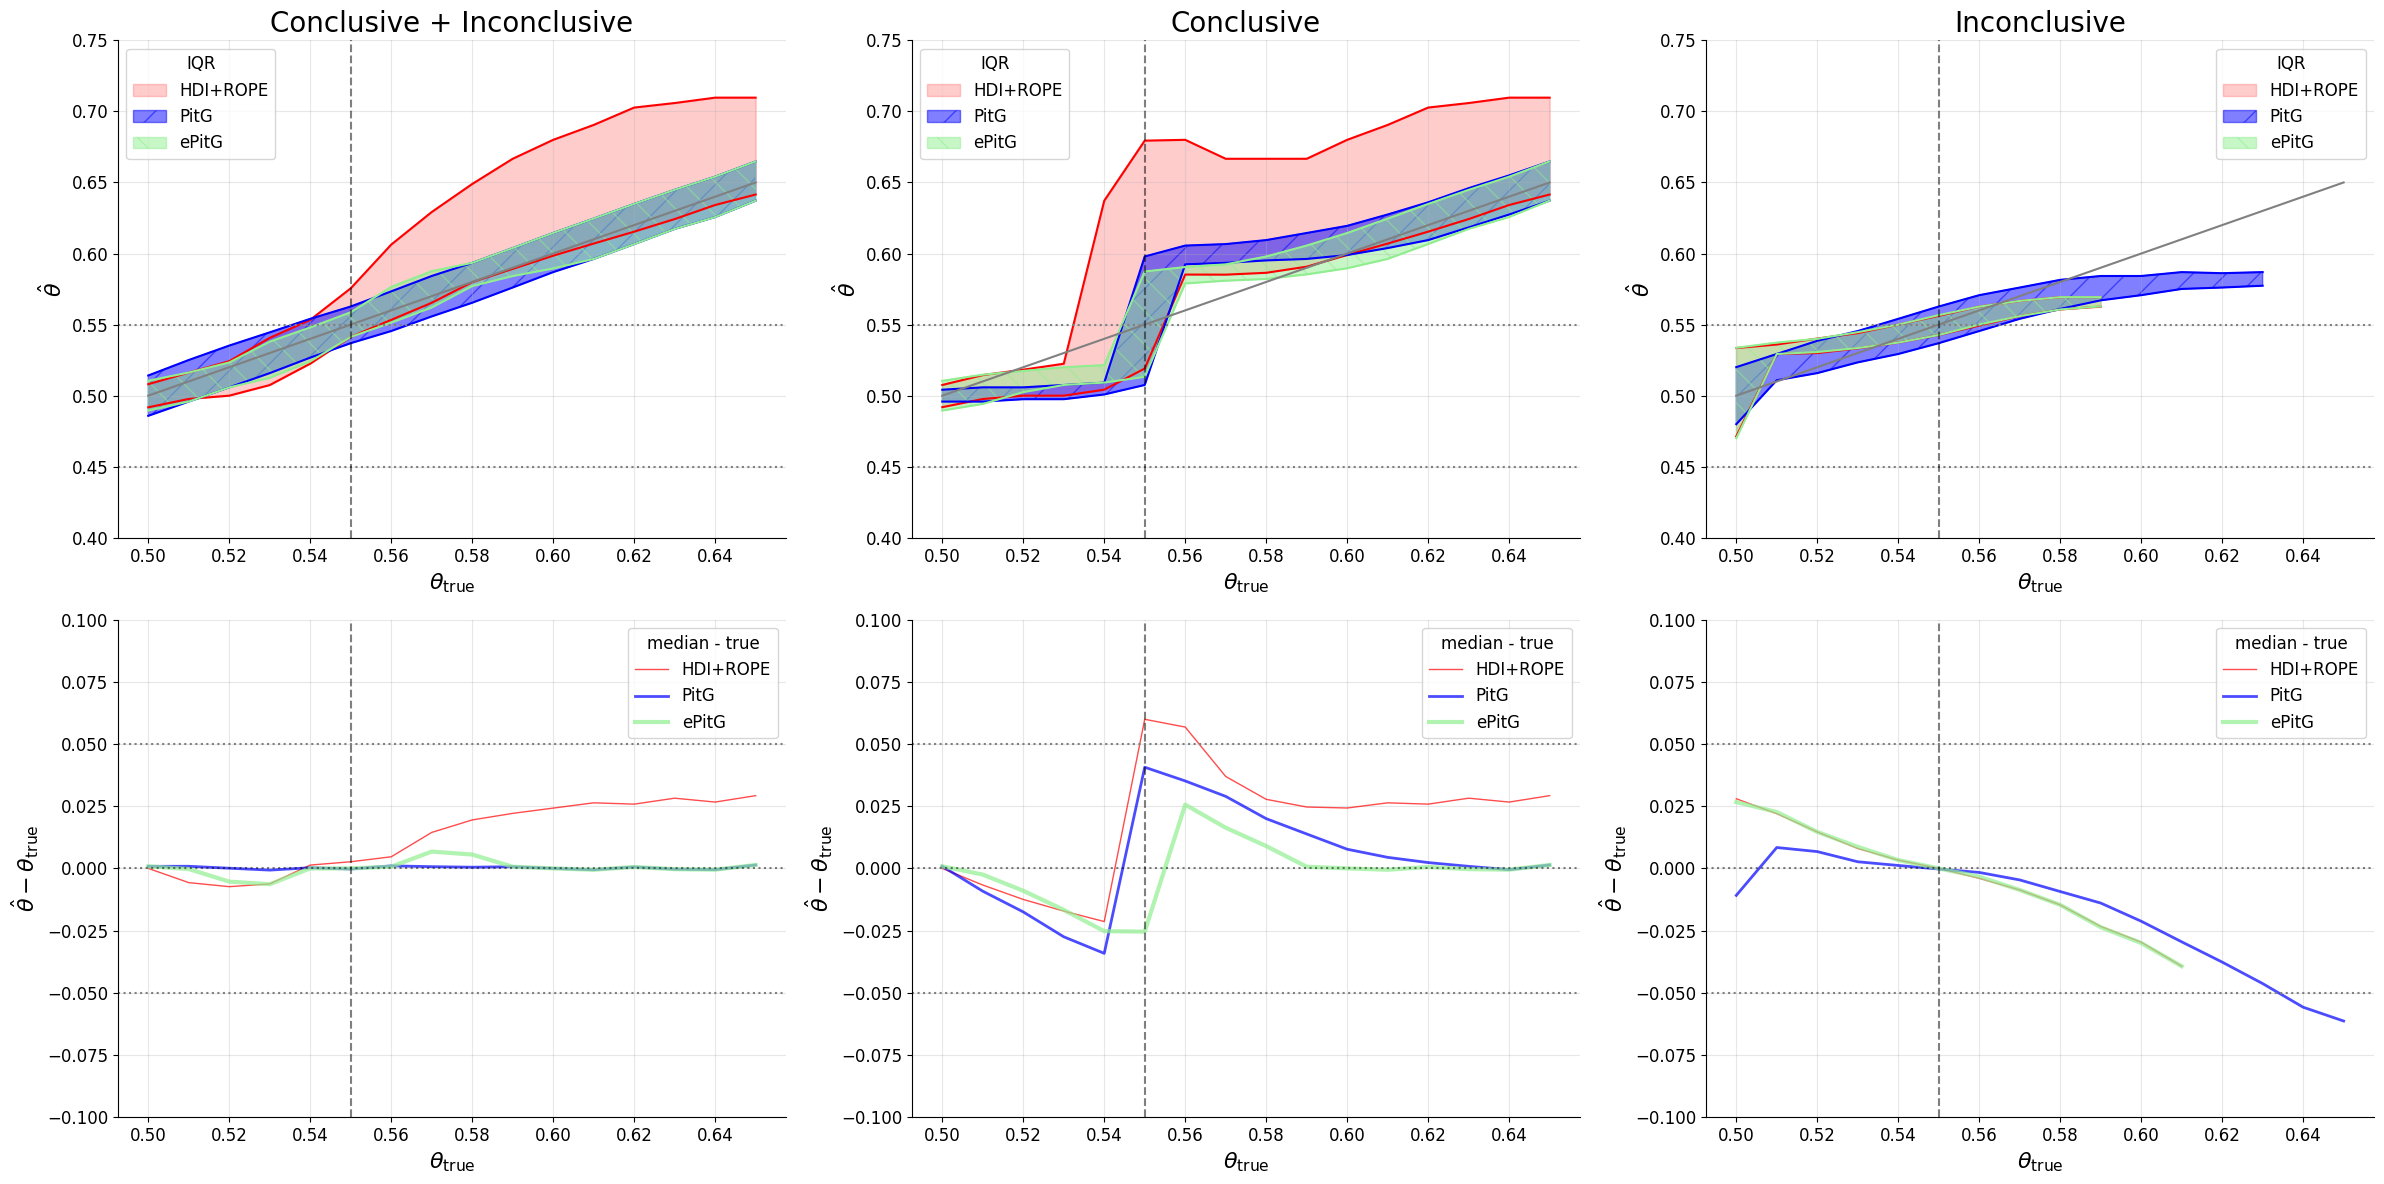

In [83]:
ncols = 3
nrows = 2

plt.figure(figsize=(ncols * FIG_WIDTH, nrows * FIG_HEIGHT))



# === Absolute Overall ===
plt.subplot(nrows, ncols,1)
plot_success_by_truth(algo_stats_df, dsuccess_rate, subset_name = "overall")

# === Absolute Conclusive===
plt.subplot(nrows, ncols,2)
plot_success_by_truth(algo_stats_df, dsuccess_rate, subset_name = "conclusive")

# === Absolute Inconclusive===
plt.subplot(nrows, ncols,3)
plot_success_by_truth(algo_stats_df, dsuccess_rate, subset_name = "inconclusive")

# === Relative Overall===
plt.subplot(nrows, ncols,4)
plot_success_by_truth_diff(algo_stats_df, dsuccess_rate, subset_name="overall", success_metrics=["param_median"])


# === Relative Conclusive===
plt.subplot(nrows, ncols,5)
plot_success_by_truth_diff(algo_stats_df, dsuccess_rate, subset_name="conclusive", success_metrics=["param_median"])


# === Relative Inconclusive===
plt.subplot(nrows, ncols,6)
plot_success_by_truth_diff(algo_stats_df, dsuccess_rate, subset_name="inconclusive", success_metrics=["param_median"])
plt.tight_layout()

#plt.savefig('../latex/images/success_by_truth.png')

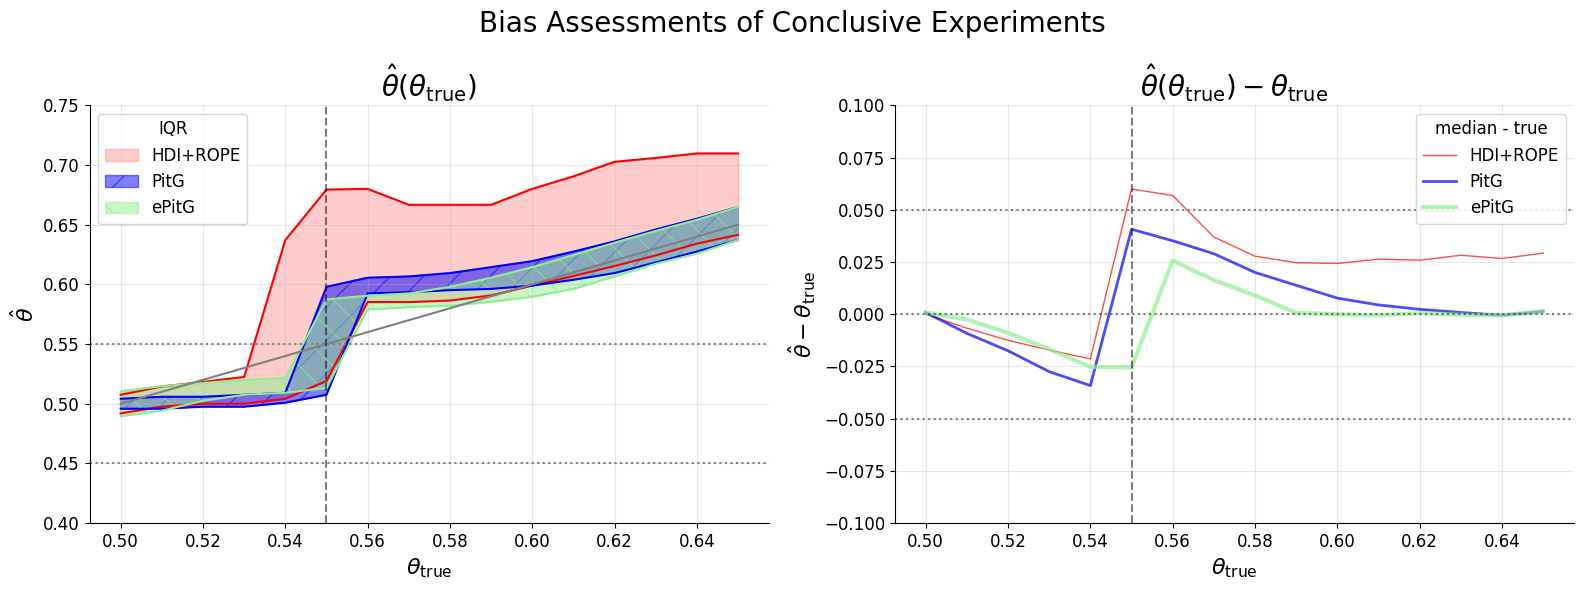

In [123]:

# ncols = 2
# nrows = 1

# plt.figure(figsize=(ncols * FIG_WIDTH, nrows * FIG_HEIGHT))

# # === Absolute Conclusive===
# plt.subplot(nrows, ncols,1)
# plot_success_by_truth(algo_stats_df, dsuccess_rate, subset_name = "conclusive")
# plt.title(r"$\hat{\theta}(\theta_{\rm true})$")

# # === Relative Conclusive===
# plt.subplot(nrows, ncols,2)
# plot_success_by_truth_diff(algo_stats_df, dsuccess_rate, subset_name="conclusive", success_metrics=["param_median"])
# plt.title(r"$\hat{\theta}(\theta_{\rm true}) - \theta_{\rm true}$")

# plt.suptitle("Bias Assessments of Conclusive Experiments", fontsize=20)

# plt.tight_layout()
plot_success_by_truth_absolute_and_diff(algo_stats_df, dsuccess_rate, subset_name="conclusive", ncols = 2, nrows = 1)
#plt.savefig('../latex/images/success_by_truth_conclusive.png')

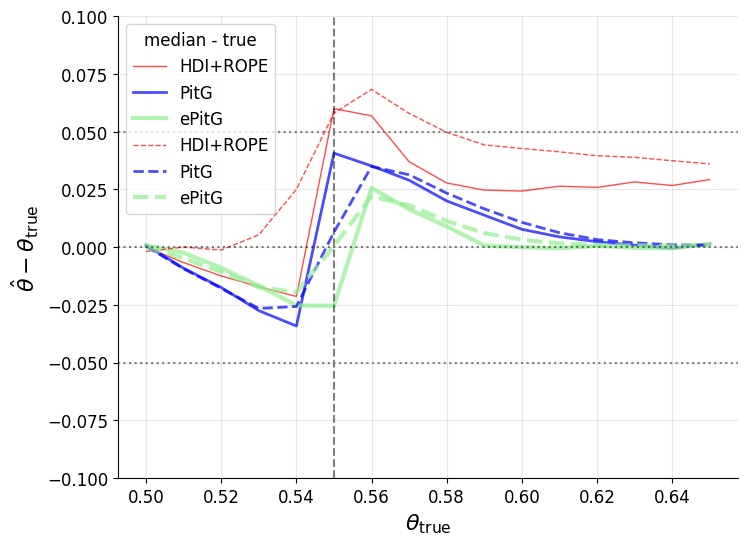

In [85]:
plot_success_by_truth_diff(algo_stats_df, dsuccess_rate, subset_name="conclusive", success_metrics=["param_median", "param_mean"])

In [86]:
# TODO: import
METHOD_SHORT = {
    "hdi_rope": "HDI+ROPE",
    "pitg": "PitG",
    "epitg": "ePitG",

}

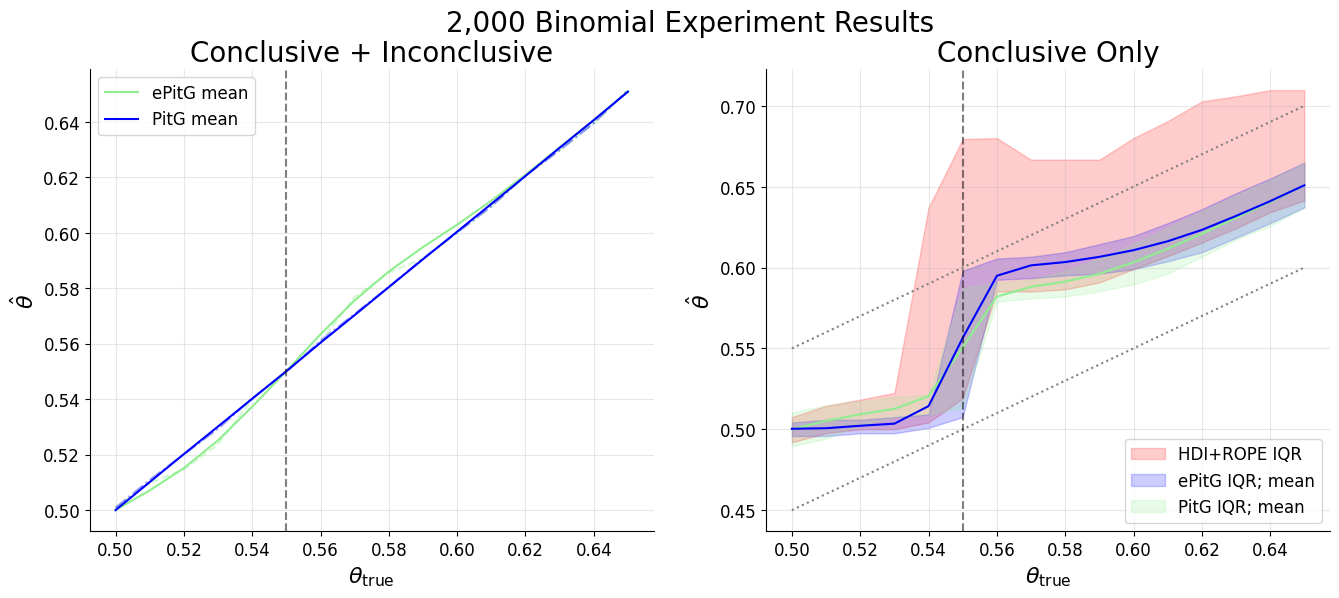

In [ ]:
# Script from here were copied above.

xvalues = np.array(algo_stats_df[subset_name]["epitg"]["param_median"].index.tolist())

rope_mins = xvalues - dsuccess_rate
rope_maxs = xvalues + dsuccess_rate

plt.figure(figsize=(2 * FIG_WIDTH, FIG_HEIGHT))

# === Conclusives ===

plt.suptitle(f"{N_EXPERIMENTS:,} Binomial Experiment Results", fontsize=20)
plt.subplot(1,2,2)

subset_name = "conclusive"
plt.title("Conclusive Only", fontsize=20)
plt.fill_between(xvalues, algo_stats_df[subset_name]["hdi_rope"]["param_p25"], algo_stats_df[subset_name]["hdi_rope"]["param_p75"], color=ALGO_COLORS["hdi_rope"], alpha=0.2, label=f"{METHOD_SHORT['hdi_rope']} IQR")

plt.fill_between(xvalues, algo_stats_df[subset_name]["pitg"]["param_p25"], algo_stats_df[subset_name]["pitg"]["param_p75"], color=ALGO_COLORS["pitg"], alpha=0.2, label=f"{METHOD_SHORT['epitg']} IQR; mean")
plt.fill_between(xvalues, algo_stats_df[subset_name]["epitg"]["param_p25"], algo_stats_df[subset_name]["epitg"]["param_p75"], color=ALGO_COLORS["epitg"], alpha=0.2, label=f"{METHOD_SHORT['pitg']} IQR; mean")
plt.plot(algo_stats_df[subset_name]["epitg"]["param_mean"],color=ALGO_COLORS["epitg"])
plt.plot(algo_stats_df[subset_name]["pitg"]["param_mean"], color=ALGO_COLORS["pitg"])


plt.plot(xvalues, rope_mins, color="gray", linestyle=":")
plt.plot(xvalues, rope_maxs, color="gray", linestyle=":")
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.xlabel(r"$\theta_{\rm true}$")
plt.ylabel(r"$\hat{\theta}$")
plt.legend()

plt.grid(alpha=0.3)


# === Overall ===
plt.subplot(1,2,1)

subset_name = "overall"
plt.title("Conclusive + Inconclusive", fontsize=20)
plt.plot(algo_stats_df[subset_name]["epitg"]["param_median"], color=ALGO_COLORS["epitg"], linestyle="--", alpha=0.4)
plt.plot(algo_stats_df[subset_name]["pitg"]["param_median"], color=ALGO_COLORS["pitg"], linestyle="-.", alpha=0.4)

plt.plot(algo_stats_df[subset_name]["epitg"]["param_mean"],color=ALGO_COLORS["epitg"], label=f"{METHOD_SHORT['epitg']} mean")
plt.plot(algo_stats_df[subset_name]["pitg"]["param_mean"], color=ALGO_COLORS["pitg"], label=f"{METHOD_SHORT['pitg']} mean")

# plt.plot(xvalues, rope_mins, color="gray", linestyle=":")
# plt.plot(xvalues, rope_maxs, color="gray", linestyle=":")
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.xlabel(r"$\theta_{\rm true}$")
plt.ylabel(r"$\hat{\theta}$")
plt.legend()


plt.grid(alpha=0.3)

In [88]:
# TODO: import
ALGO_LINEWIDTH =  {"hdi_rope":1, "pitg": 2, "epitg":3}

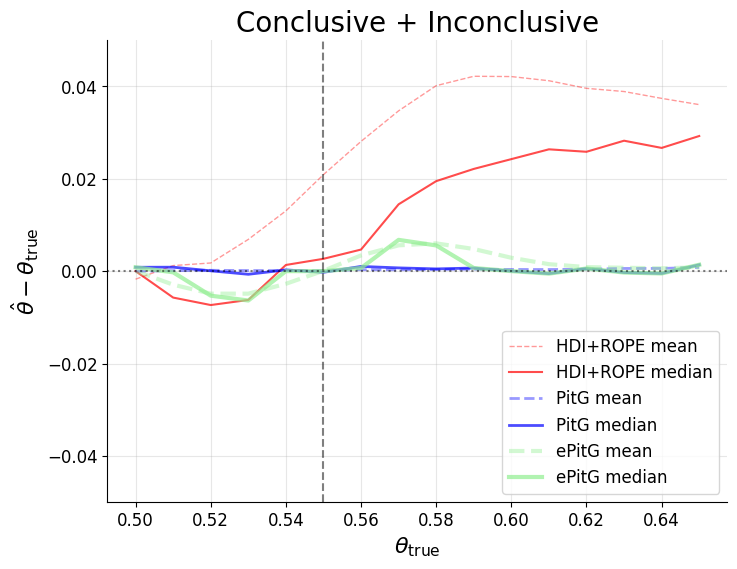

In [89]:
subset_name = "overall"

plt.title("Conclusive + Inconclusive", fontsize=20)
hdirope_median_diff = algo_stats_df[subset_name]["hdi_rope"]["param_median"] - xvalues
hdirope_mean_diff = algo_stats_df[subset_name]["hdi_rope"]["param_mean"] - xvalues
epitg_median_diff = algo_stats_df[subset_name]["epitg"]["param_median"] - xvalues
pit_median_diff = algo_stats_df[subset_name]["pitg"]["param_median"] - xvalues
epitg_mean_diff = algo_stats_df[subset_name]["epitg"]["param_mean"] - xvalues
pit_mean_diff = algo_stats_df[subset_name]["pitg"]["param_mean"] - xvalues

plt.plot(xvalues, hdirope_mean_diff, color=ALGO_COLORS["hdi_rope"], linestyle="--", alpha=0.4, label=f"{METHOD_SHORT['hdi_rope']} mean", linewidth=ALGO_LINEWIDTH["hdi_rope"])
plt.plot(xvalues, hdirope_median_diff, color=ALGO_COLORS["hdi_rope"], linestyle=None, alpha=0.7, label=f"{METHOD_SHORT['hdi_rope']} median")

plt.plot(xvalues, pit_mean_diff, color=ALGO_COLORS["pitg"], linestyle="--", alpha=0.4, label=f"{METHOD_SHORT['pitg']} mean", linewidth=ALGO_LINEWIDTH["pitg"])
plt.plot(xvalues, pit_median_diff, color=ALGO_COLORS["pitg"], linestyle=None, alpha=0.7, label=f"{METHOD_SHORT['pitg']} median", linewidth=ALGO_LINEWIDTH["pitg"])

plt.plot(xvalues, epitg_mean_diff, color=ALGO_COLORS["epitg"], linestyle="--", alpha=0.4, label=f"{METHOD_SHORT['epitg']} mean", linewidth=ALGO_LINEWIDTH["epitg"])
plt.plot(xvalues, epitg_median_diff, color=ALGO_COLORS["epitg"], linestyle=None, alpha=0.7, label=f"{METHOD_SHORT['epitg']} median", linewidth=ALGO_LINEWIDTH["epitg"])

plt.axhline(y=0, color="black", linestyle=":", alpha=0.5)
plt.xlabel(r"$\theta_{\rm true}$")
plt.ylabel(r"$\hat{\theta} - \theta_{\rm true}$")
plt.legend()
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.ylim(-dsuccess_rate,dsuccess_rate)

plt.grid(alpha=0.3)

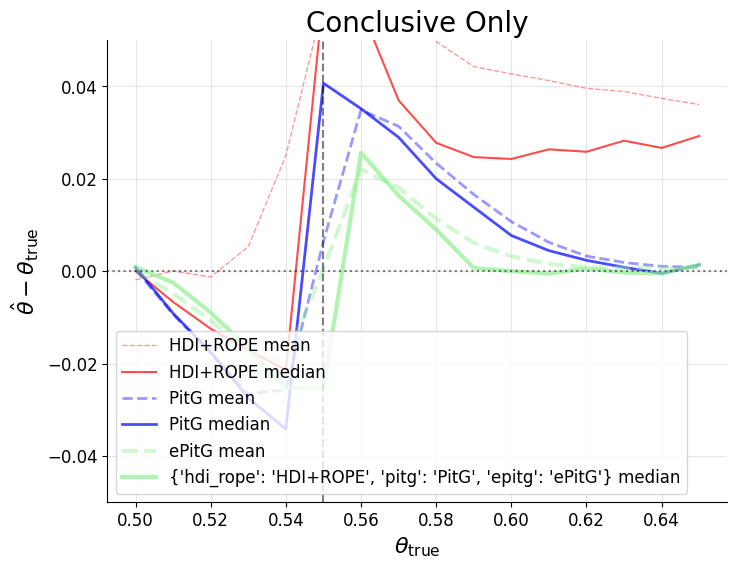

In [90]:
# This was copied above

subset_name = "conclusive"
plt.title("Conclusive Only", fontsize=20)

hdirope_median_diff = algo_stats_df[subset_name]["hdi_rope"]["param_median"] - xvalues
hdirope_mean_diff = algo_stats_df[subset_name]["hdi_rope"]["param_mean"] - xvalues
epitg_median_diff = algo_stats_df[subset_name]["epitg"]["param_median"] - xvalues
pit_median_diff = algo_stats_df[subset_name]["pitg"]["param_median"] - xvalues

epitg_mean_diff = algo_stats_df[subset_name]["epitg"]["param_mean"] - xvalues
pit_mean_diff = algo_stats_df[subset_name]["pitg"]["param_mean"] - xvalues

plt.plot(xvalues, hdirope_mean_diff, color=ALGO_COLORS["hdi_rope"], linestyle="--", alpha=0.4, label=f"{METHOD_SHORT['hdi_rope']} mean", linewidth=ALGO_LINEWIDTH["hdi_rope"])
plt.plot(xvalues, hdirope_median_diff, color=ALGO_COLORS["hdi_rope"], linestyle=None, alpha=0.7, label=f"{METHOD_SHORT['hdi_rope']} median")

plt.plot(xvalues, pit_mean_diff, color=ALGO_COLORS["pitg"], linestyle="--", alpha=0.4, label=f"{METHOD_SHORT['pitg']} mean", linewidth=ALGO_LINEWIDTH["pitg"])
plt.plot(xvalues, pit_median_diff, color=ALGO_COLORS["pitg"], linestyle=None, alpha=0.7, label=f"{METHOD_SHORT['pitg']} median", linewidth=ALGO_LINEWIDTH["pitg"])

plt.plot(xvalues, epitg_mean_diff, color=ALGO_COLORS["epitg"], linestyle="--", alpha=0.4, label=f"{METHOD_SHORT['epitg']} mean", linewidth=ALGO_LINEWIDTH["epitg"])
plt.plot(xvalues, epitg_median_diff, color=ALGO_COLORS["epitg"], linestyle=None, alpha=0.7, label=f"{METHOD_SHORT} median", linewidth=ALGO_LINEWIDTH["epitg"])

plt.axhline(y=0, color="black", linestyle=":", alpha=0.5)
plt.xlabel(r"$\theta_{\rm true}$")
plt.ylabel(r"$\hat{\theta} - \theta_{\rm true}$")
plt.legend()
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.ylim(-dsuccess_rate,dsuccess_rate)

plt.grid(alpha=0.3)

In [91]:
sims_hypo0pt5_results[0.55].keys()

dict_keys(['synth', 'hypothesis', 'df_stats'])

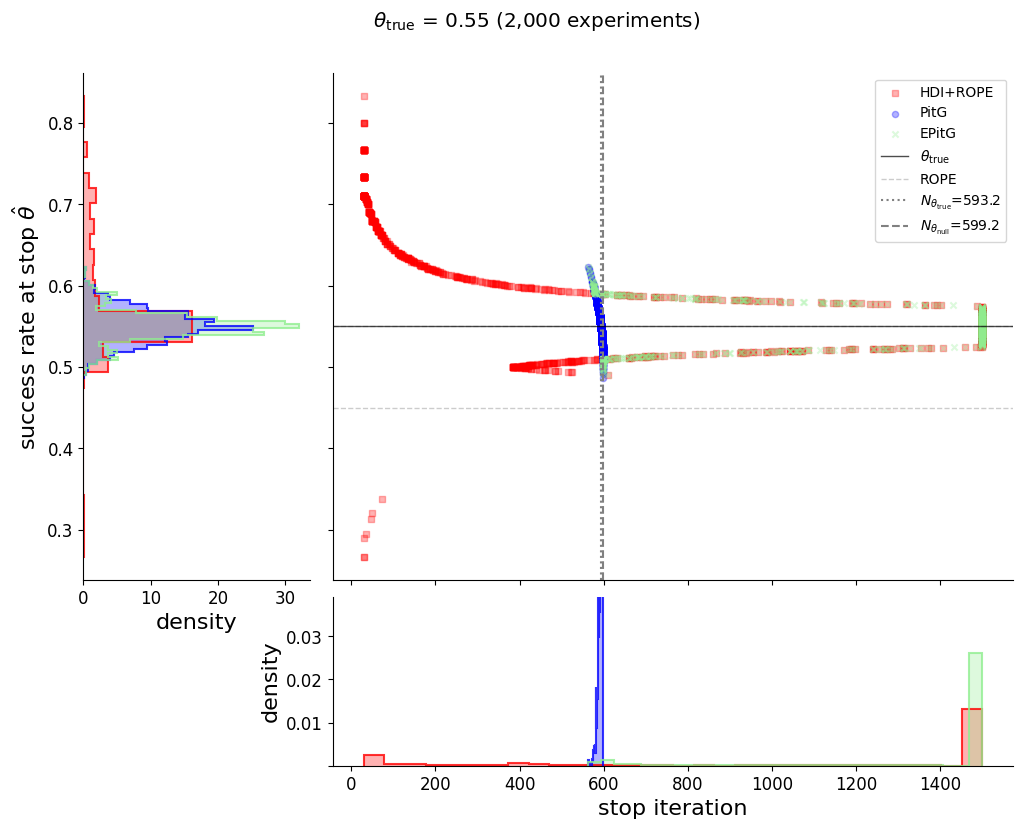

In [92]:
sims_hypo0pt5_results[0.55]['hypothesis'].plot_stop_iter_sample_rates(success_rate=sims_hypo0pt5_results[0.55]['synth'].success_rate, title=None)

viz_epitg separate


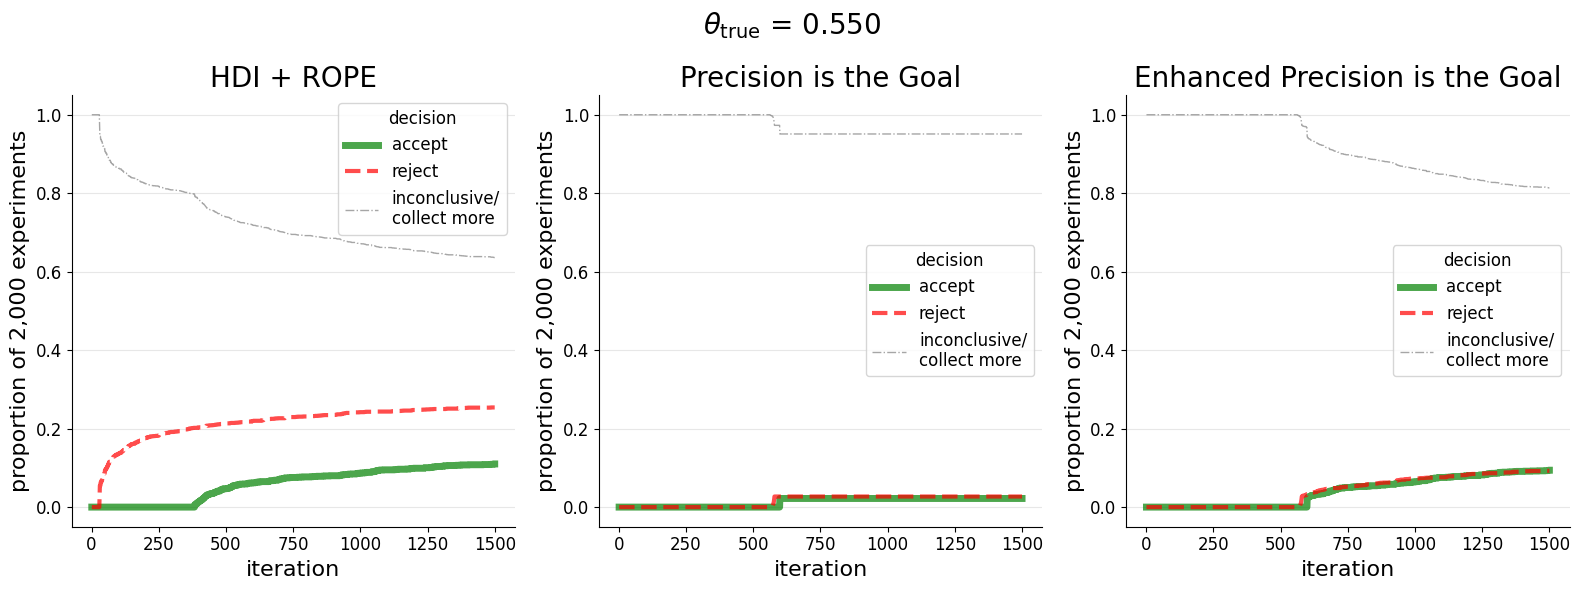

In [93]:
sims_hypo0pt5_results[0.55]['hypothesis'].plot_decision_rates(sims_hypo0pt5_results[0.55]['synth'].success_rate)

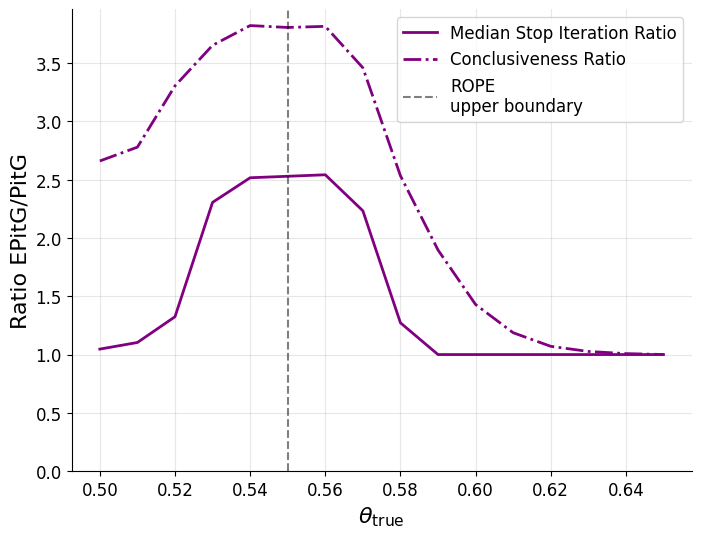

In [140]:
plot_stop_and_conclusive_ratios(algo_stats_df, subset_name = "overall", param_null=null_rate_fair, dsuccess_rate=dsuccess_rate, viz_mean=False)
#plt.savefig('../latex/images/stop_conclusiveness_ratios.png')

In [95]:
sims_hypo0pt5_results[0.5].keys()

dict_keys(['synth', 'hypothesis', 'df_stats'])

In [96]:
sims_hypo0pt5_results[0.5]['hypothesis'].__dict__.keys()

dict_keys(['success_rate_null', 'dsuccess_rate', 'rope_precision_fraction', 'rope_min', 'rope_max', 'precision_goal', 'experiments', 'n_experiments', 'method_stats', 'method_roperesult_iteration', 'method_df_stats', 'method_df_iteration_counts', 'df_experiments_summary', 'df_experiment_correctness'])

In [97]:
sims_hypo0pt5_results[0.5]['hypothesis'].df_experiments_summary

,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.9210,0.061,0.9820,0.0180,592.9835,290.737790,0.498253,0.051782
pitg,0.3670,0.000,0.3670,0.6330,598.2090,1.457526,0.499978,0.020554
epitg,0.9765,0.000,0.9765,0.0235,740.9665,221.187573,0.500032,0.013120


## Correctness

In [98]:
correctness_stats(sims_hypo0pt5_results[0.54]['hypothesis'].df_experiment_correctness)

{'inconclusive_rates': hdi_rope_inconclusive    0.5705
 pitg_inconclusive        0.9240
 epitg_inconclusive       0.7095
 dtype: float64,
 'correctness_rates': hdi_rope_decision_correct    0.7020
 pitg_decision_correct        0.6970
 epitg_decision_correct       0.7955
 dtype: float64,
 'correctness_rates_pitg_inconclusive': hdi_rope_decision_correct    0.689935
 pitg_decision_correct        0.681277
 epitg_decision_correct       0.787879
 dtype: float64}

In [99]:
inconclusive_rates = {}
correctness_rates = {}
correctness_rates_pitg_inconclusive = {}

for theta_true in sims_hypo0pt5_results.keys():
    correctness_ = correctness_stats(sims_hypo0pt5_results[theta_true]['hypothesis'].df_experiment_correctness)

    inconclusive_rates[theta_true] = correctness_['inconclusive_rates']
    correctness_rates[theta_true] = correctness_['correctness_rates']
    correctness_rates_pitg_inconclusive[theta_true] = correctness_['correctness_rates_pitg_inconclusive']


df_inconclusive_rates = pd.DataFrame(inconclusive_rates).T.sort_index()
df_correctness_rates = pd.DataFrame(correctness_rates).T.sort_index()
df_correctness_rates_pitg_inconclusive = pd.DataFrame(correctness_rates_pitg_inconclusive).T.sort_index()

In [100]:
df_inconclusive_rates * 100.

,hdi_rope_inconclusive,pitg_inconclusive,epitg_inconclusive
0.50,1.80,63.30,2.35
0.51,5.15,66.45,6.75
0.52,18.00,76.40,22.00
0.53,37.50,85.30,46.30
0.54,57.05,92.40,70.95
0.55,63.60,95.10,81.35
0.56,55.20,92.40,71.00
0.57,34.40,84.25,45.50
0.58,14.65,68.25,19.55
0.59,3.05,49.55,4.30


In [101]:
df_correctness_rates

,hdi_rope_decision_correct,pitg_decision_correct,epitg_decision_correct
0.50,0.9385,0.9850,0.9995
0.51,0.9285,0.9755,0.9985
0.52,0.9165,0.9335,0.9900
0.53,0.8465,0.8425,0.9420
0.54,0.7020,0.6970,0.7955
0.55,0.4420,0.5110,0.5075
0.56,0.8105,0.6800,0.7845
0.57,0.9535,0.8270,0.9475
0.58,0.9925,0.9290,0.9910
0.59,1.0000,0.9740,0.9995


In [102]:
df_correctness_rates["epitg_decision_correct"] - df_correctness_rates_pitg_inconclusive["epitg_decision_correct"]

0.50    0.000290
0.51    0.000005
0.52    0.001126
0.53    0.007064
0.54    0.007621
0.55   -0.003015
0.56    0.013937
0.57    0.009221
0.58    0.004187
0.59    0.000509
0.60    0.000000
0.61    0.000000
0.62    0.000000
0.63    0.000000
0.64    0.000000
0.65    0.000000
Name: epitg_decision_correct, dtype: float64

In [103]:
df_correctness_rates_pitg_inconclusive

,hdi_rope_decision_correct,pitg_decision_correct,epitg_decision_correct
0.50,0.927330,0.976303,0.999210
0.51,0.917231,0.963883,0.998495
0.52,0.907723,0.914921,0.988874
0.53,0.828839,0.818288,0.934936
0.54,0.689935,0.681277,0.787879
0.55,0.443743,0.514196,0.510515
0.56,0.798701,0.657468,0.770563
0.57,0.945401,0.795252,0.938279
0.58,0.989011,0.895971,0.986813
0.59,1.000000,0.947528,0.998991


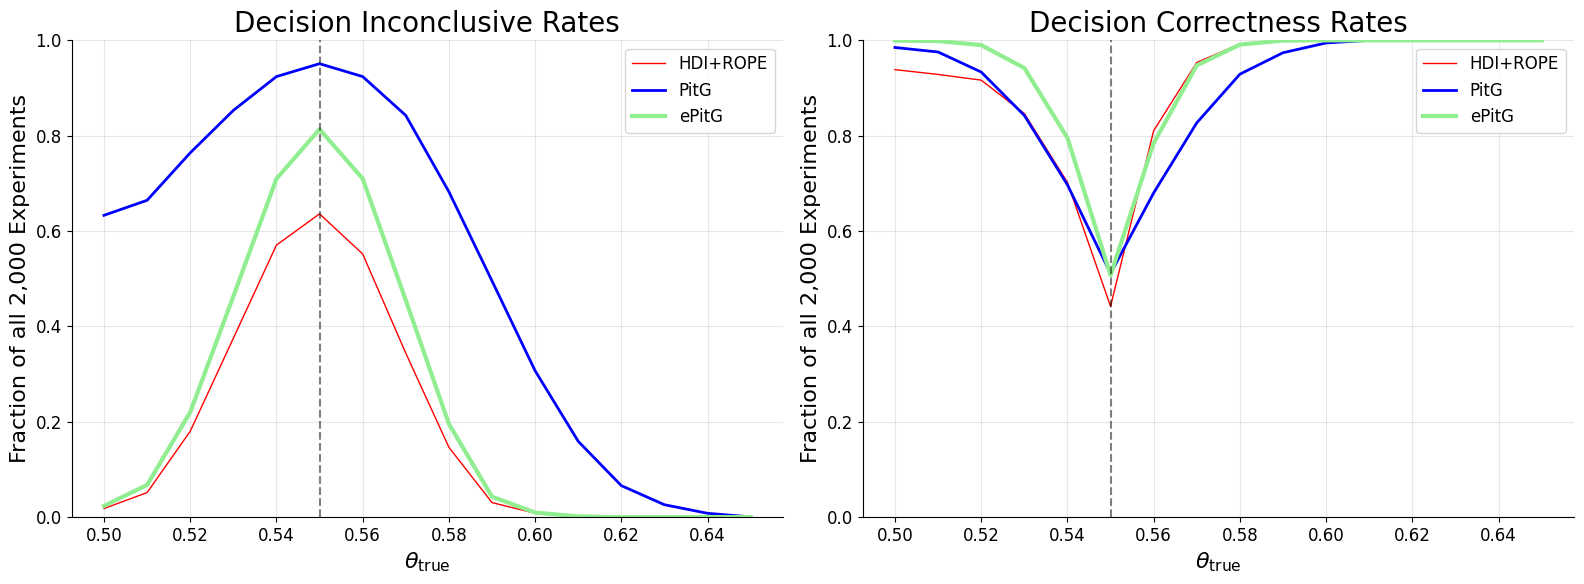

In [104]:
plt.figure(figsize=(2 * FIG_WIDTH, FIG_HEIGHT))

plt.subplot(1, 2, 1)
for algo_name in method_names:
    plt.plot(df_inconclusive_rates[f"{algo_name}_inconclusive"], color=ALGO_COLORS[algo_name], label=f"{METHOD_SHORT[algo_name]}", linewidth=ALGO_LINEWIDTH[algo_name])


plt.ylim(0., 1.)
plt.grid(alpha=0.3)
plt.legend()

plt.xlabel(r"$\theta_{\rm true}$")
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.title("Decision Inconclusive Rates")
plt.ylabel(f"Fraction of all {N_EXPERIMENTS:,} Experiments")


plt.subplot(1,2,2)

for algo_name in method_names:
    plt.plot(df_correctness_rates[f"{algo_name}_decision_correct"], color=ALGO_COLORS[algo_name], label=f"{METHOD_SHORT[algo_name]}", linewidth=ALGO_LINEWIDTH[algo_name])


plt.ylim(0., 1.)
plt.grid(alpha=0.3)
plt.legend()

plt.xlabel(r"$\theta_{\rm true}$")
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.title("Decision Correctness Rates")
plt.ylabel(f"Fraction of all {N_EXPERIMENTS:,} Experiments")

plt.tight_layout()

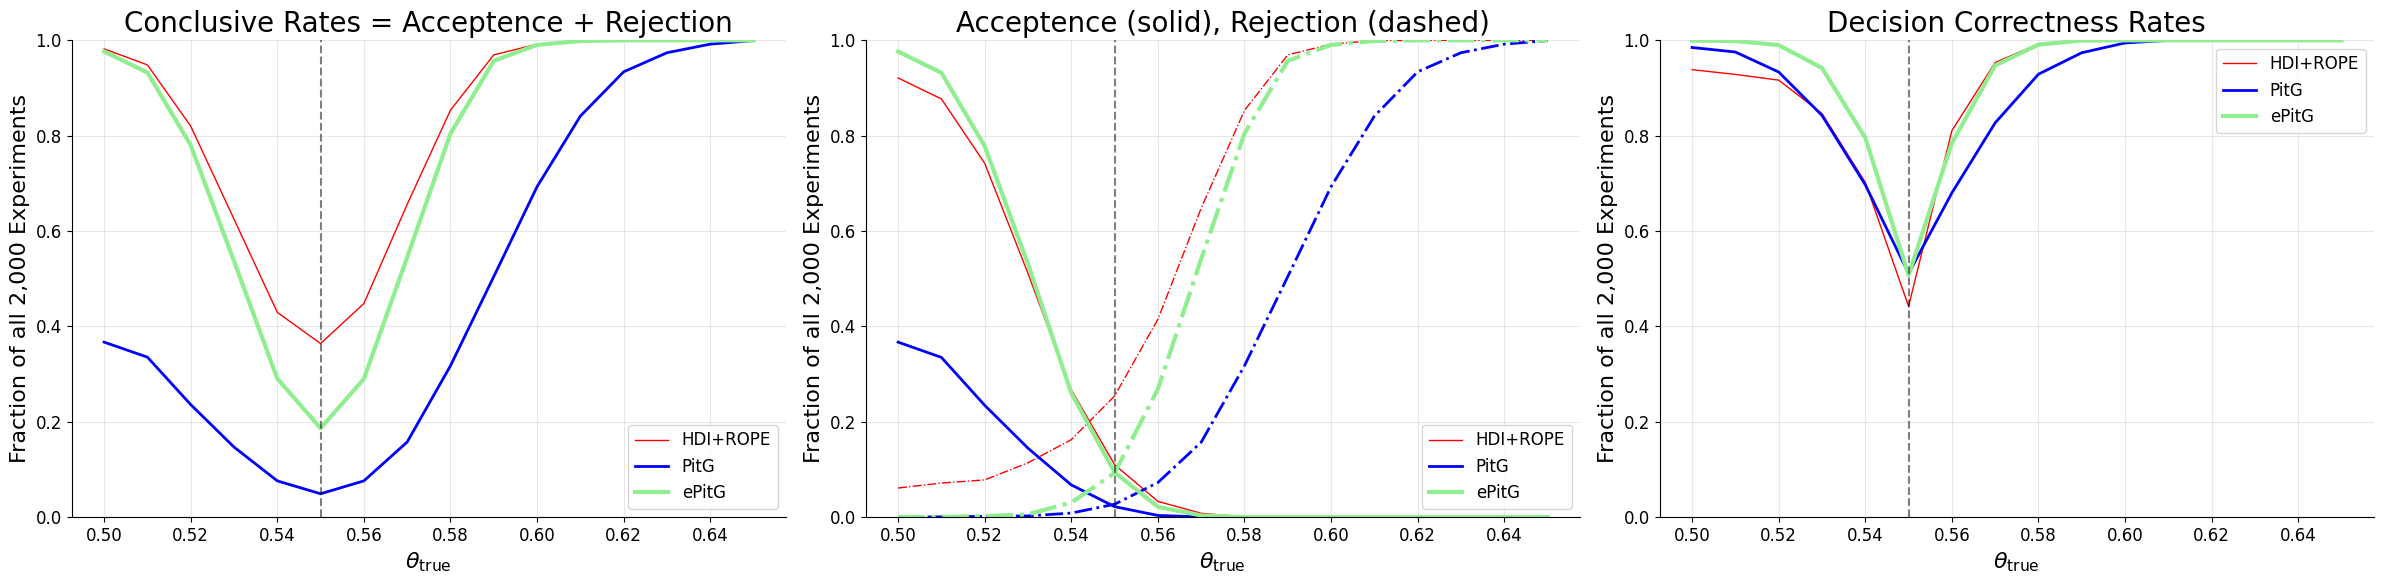

In [ ]:
#ALGO_NAME = {"hdi_rope":"HDI+ROPE", "pitg": "PitG", "epitg": "ePitG"}
#ALGO_LINEWIDTH =  {"hdi_rope":1, "pitg": 2, "epitg":3}

subset_name = "overall"

plt.figure(figsize=(3 * FIG_WIDTH, FIG_HEIGHT))

# Conclusive Rates
plt.subplot(1, 3, 1)
for algo_name in METHOD_SHORT:
    plt.plot(algo_stats_df[subset_name][algo_name]["conclusive_mean"],
    color=ALGO_COLORS[algo_name], label=METHOD_SHORT[algo_name], linewidth=ALGO_LINEWIDTH[algo_name])

plt.grid(alpha=0.3)
plt.xlabel(r"$\theta_{\rm true}$")
plt.legend()
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.title("Conclusive Rates = Acceptence + Rejection")
plt.ylabel(f"Fraction of all {N_EXPERIMENTS:,} Experiments")

plt.ylim(0.,1)

# Acceptence + Rejection Rates
plt.subplot(1, 3, 2)
for algo_name in METHOD_SHORT:
    plt.plot(algo_stats_df[subset_name][algo_name]["accept_mean"],
    color=ALGO_COLORS[algo_name], label=METHOD_SHORT[algo_name], linewidth=ALGO_LINEWIDTH[algo_name])

    plt.plot(algo_stats_df[subset_name][algo_name]["reject_mean"],
        color=ALGO_COLORS[algo_name], linewidth=ALGO_LINEWIDTH[algo_name], linestyle="-.")

plt.grid(alpha=0.3)
plt.xlabel(r"$\theta_{\rm true}$")
plt.ylabel(f"Fraction of all {N_EXPERIMENTS:,} Experiments")
plt.title("Acceptence (solid), Rejection (dashed)")
plt.legend()
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.ylim(0.,1)

# Correctness Rates
plt.subplot(1, 3, 3)
for algo_name in method_names:
    plt.plot(df_correctness_rates[f"{algo_name}_decision_correct"], color=ALGO_COLORS[algo_name], label=f"{METHOD_SHORT[algo_name]}", linewidth=ALGO_LINEWIDTH[algo_name])

plt.ylim(0., 1.)
plt.grid(alpha=0.3)
plt.legend()

plt.xlabel(r"$\theta_{\rm true}$")
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.title("Decision Correctness Rates")
plt.ylabel(f"Fraction of all {N_EXPERIMENTS:,} Experiments")

plt.tight_layout()
# plt.savefig('../latex/images/conclusive_rates.png')

Text(0, 0.5, 'Fraction of all 2,000 Experiments')

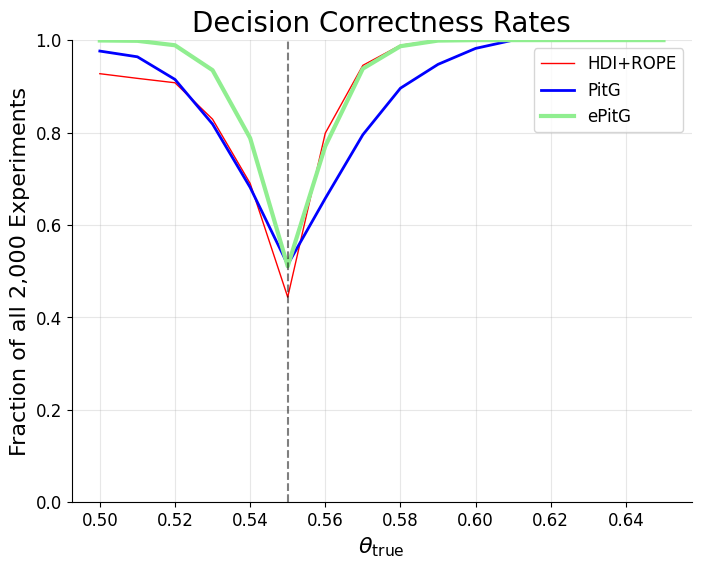

In [106]:
for algo_name in method_names:
    plt.plot(df_correctness_rates_pitg_inconclusive[f"{algo_name}_decision_correct"], color=ALGO_COLORS[algo_name], label=f"{METHOD_SHORT[algo_name]}", linewidth=ALGO_LINEWIDTH[algo_name])


plt.ylim(0., 1.)
plt.grid(alpha=0.3)
plt.legend()

plt.xlabel(r"$\theta_{\rm true}$")
plt.axvline(x=0.5 + dsuccess_rate, color="black", linestyle="--", alpha=0.5)

plt.title("Decision Correctness Rates")
plt.ylabel(f"Fraction of all {N_EXPERIMENTS:,} Experiments")


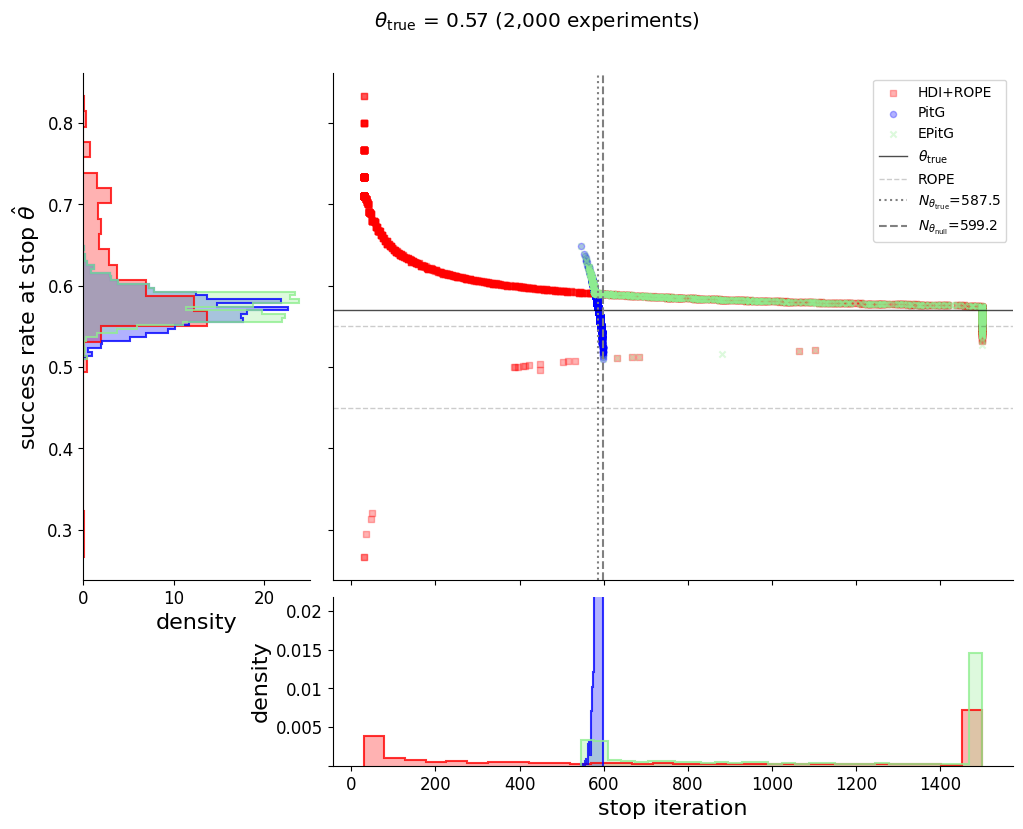

In [107]:
sims_hypo0pt5_results[0.57]['hypothesis'].plot_stop_iter_sample_rates(success_rate=sims_hypo0pt5_results[0.57]['synth'].success_rate, title=None)

#plt.savefig("../latex/images/loaded0pt57_experiments_iter_vs_rate.png")


viz_epitg separate


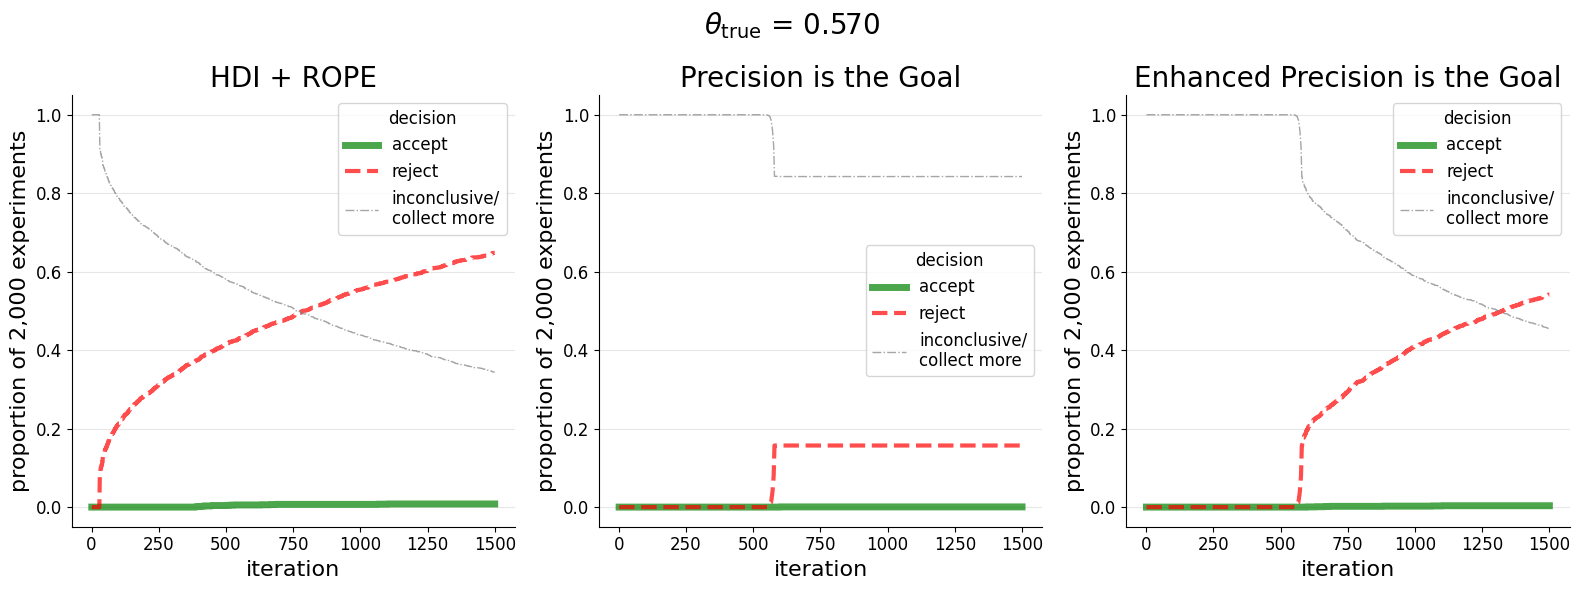

In [108]:

sims_hypo0pt5_results[0.57]['hypothesis'].plot_decision_rates(sims_hypo0pt5_results[0.57]['synth'].success_rate, viz_epitg="separate")
#plt.savefig("../latex/images/loaded0pt57_experiment_decision_rates.png")

# $\theta_{\rm null}=0.7$

In [114]:
%%time
sims_hypo0pt7_results = {}

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 11 µs


In [113]:
null_rate_loaded = 0.7

In [115]:
sim_true_rates = [0.5, 0.6, 0.65, 0.7, 0.75,0.8, 0.9]

for this_rate in sim_true_rates:
    sims_hypo0pt7_results[this_rate] = run_simulations_and_analysis_report(
        binary_accounting,
        success_rate_true=this_rate,
        success_rate_null=null_rate_loaded,
        dsuccess_rate=dsuccess_rate,
        n_experiments=N_EXPERIMENTS,
        n_samples=N_SAMPLES,
        rope_precision_fraction=rope_precision_fraction,
        seed=SEED,
        viz=False
    )

    report_accounting_size(binary_accounting)
    print("-" * 40)

Generating synthetic data with parameter values:
0.5: true success rate
2000: experiments
1500: sample size per experiment
0.7: null hypothesis
0.65: ROPE min
0.75: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.0,1.0,0.0,49.6535,31.106981,0.471758,0.063766
pitg,0.0,1.0,1.0,0.0,598.2090,1.457526,0.499978,0.020554
epitg,0.0,1.0,1.0,0.0,598.2090,1.457526,0.499978,0.020554


Binary Accounting Report
137,217 elements
Most frequent count value: 477 (appears 143 times (of 137,217 0.10%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.6: true success rate
2000: experiments
1500: sample size per experiment
0.7: null hypothesis
0.65: ROPE min
0.75: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0015,0.9960,0.9975,0.0025,286.4475,294.847828,0.558756,0.058059
pitg,0.0000,0.6725,0.6725,0.3275,574.0995,10.032693,0.600358,0.020512
epitg,0.0000,0.9955,0.9955,0.0045,645.4110,161.847386,0.597647,0.016752


Binary Accounting Report
159,271 elements
Most frequent count value: 477 (appears 143 times (of 159,271 0.09%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.65: true success rate
2000: experiments
1500: sample size per experiment
0.7: null hypothesis
0.65: ROPE min
0.75: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.1335,0.2205,0.3540,0.6460,1104.673,575.611319,0.634562,0.061285
pitg,0.0260,0.0260,0.0520,0.9480,543.642,15.324466,0.650811,0.020900
epitg,0.1100,0.0865,0.1965,0.8035,1353.978,318.875313,0.650789,0.019023


Binary Accounting Report
193,694 elements
Most frequent count value: 1,439 (appears 169 times (of 193,694 0.09%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.7: true success rate
2000: experiments
1500: sample size per experiment
0.7: null hypothesis
0.65: ROPE min
0.75: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.9315,0.0625,0.9940,0.0060,503.4755,253.949555,0.703951,0.047881
pitg,0.3835,0.0000,0.3835,0.6165,501.1045,20.766420,0.700835,0.021128
epitg,0.9935,0.0000,0.9935,0.0065,625.7835,197.336559,0.700294,0.012858


Binary Accounting Report
218,125 elements
Most frequent count value: 1,226 (appears 179 times (of 218,125 0.08%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.75: true success rate
2000: experiments
1500: sample size per experiment
0.7: null hypothesis
0.65: ROPE min
0.75: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0990,0.2965,0.3955,0.6045,1037.1025,621.295702,0.772097,0.052146
pitg,0.0205,0.0385,0.0590,0.9410,446.2945,25.542552,0.751059,0.020881
epitg,0.0920,0.1340,0.2260,0.7740,1322.3660,361.661037,0.751394,0.018999


Binary Accounting Report
255,671 elements
Most frequent count value: 1,469 (appears 233 times (of 255,671 0.09%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.8: true success rate
2000: experiments
1500: sample size per experiment
0.7: null hypothesis
0.65: ROPE min
0.75: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.0000,1.0000,0.0000,187.5295,215.387019,0.835651,0.042921
pitg,0.0,0.7120,0.7120,0.2880,377.9405,34.771691,0.802062,0.022209
epitg,0.0,0.9995,0.9995,0.0005,423.3315,138.889264,0.804076,0.019677


Binary Accounting Report
257,721 elements
Most frequent count value: 1,469 (appears 233 times (of 257,721 0.09%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------
Generating synthetic data with parameter values:
0.9: true success rate
2000: experiments
1500: sample size per experiment
0.7: null hypothesis
0.65: ROPE min
0.75: ROPE max
--------------------
0.08: Precision Goal


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,success_rate_mean,success_rate_std
hdi_rope,0.0,1.0,1.0,0.0,34.0545,10.616020,0.908774,0.042951
pitg,0.0,1.0,1.0,0.0,185.8435,66.856203,0.911134,0.031604
epitg,0.0,1.0,1.0,0.0,185.8435,66.856203,0.911134,0.031604


Binary Accounting Report
258,438 elements
Most frequent count value: 1,469 (appears 233 times (of 258,438 0.09%))
Max sum 1,500
e.g, key (799, 701) appears 185 time(s) yiedling (0.5074142760260834, 0.5578881163957048) HDI limits

----------------------------------------


In [118]:
sims_hypo0pt7_results.keys()

dict_keys([0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9])

In [119]:
hypo0pt7_algo_stats_df = sims_hypo_dict_to_algo_stats_dfs(sims_hypo0pt7_results)

hypo0pt7_algo_stats_df['overall']['epitg']

stat,count,stop_iter_p25,stop_iter_median,stop_iter_p75,stop_iter_mean,param_mean,param_p25,param_median,param_p75,conclusive_mean,accept_mean,reject_mean
theta_true,,,,,,,,,,,,
0.50,2000.0,598.0,599.0,599.00,598.2090,0.499978,0.485810,0.500835,0.514190,1.0000,0.0000,1.0000
0.60,2000.0,577.0,582.0,599.00,645.4110,0.597647,0.586919,0.600000,0.610829,0.9955,0.0000,0.9955
0.65,2000.0,1500.0,1500.0,1500.00,1353.9780,0.650789,0.642000,0.650000,0.659333,0.1965,0.1100,0.0865
0.70,2000.0,504.0,527.0,674.25,625.7835,0.700294,0.689464,0.699801,0.710630,0.9935,0.9935,0.0000
0.75,2000.0,1500.0,1500.0,1500.00,1322.3660,0.751394,0.742667,0.750667,0.758667,0.2260,0.0920,0.1340
0.80,2000.0,361.0,381.0,414.00,423.3315,0.804076,0.789855,0.800525,0.814404,0.9995,0.0000,0.9995
0.90,2000.0,160.0,201.0,233.00,185.8435,0.911134,0.888412,0.905473,0.925000,1.0000,0.0000,1.0000


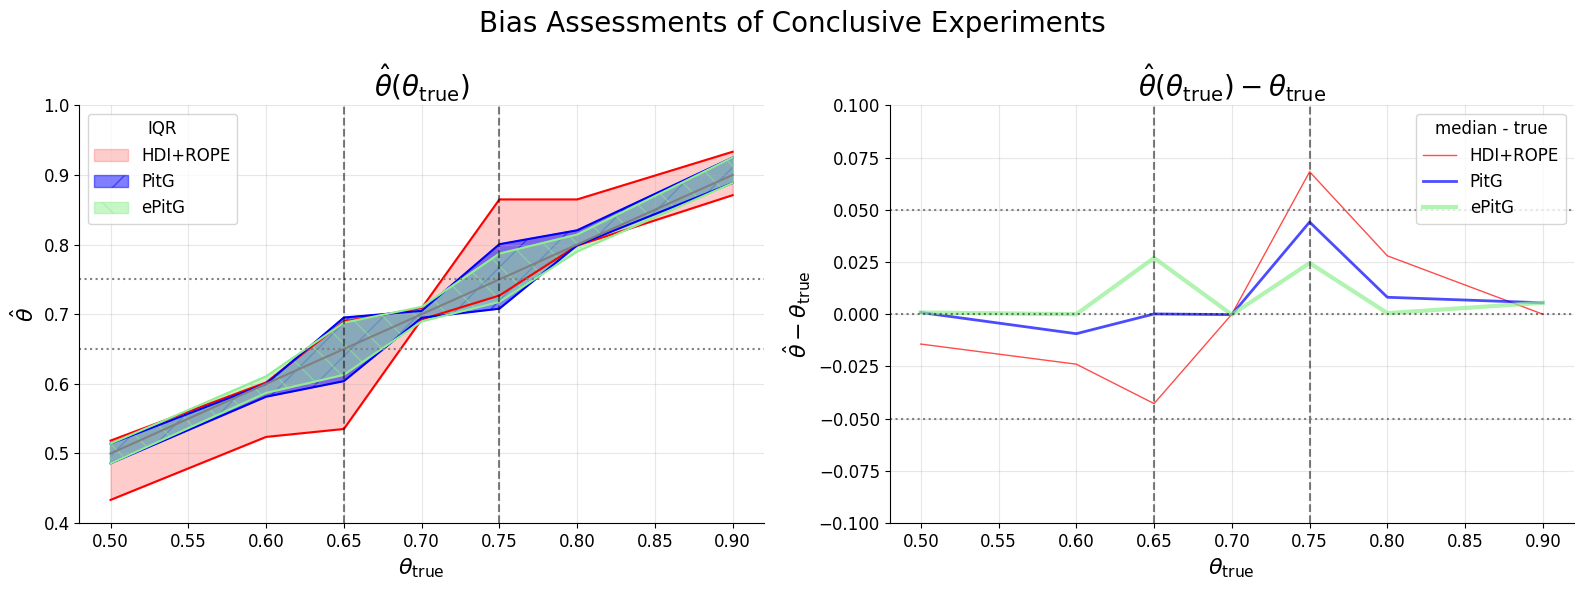

In [131]:
plot_success_by_truth_absolute_and_diff(hypo0pt7_algo_stats_df, dsuccess_rate, subset_name="conclusive", ncols = 2, nrows = 1, param_null=null_rate_loaded)


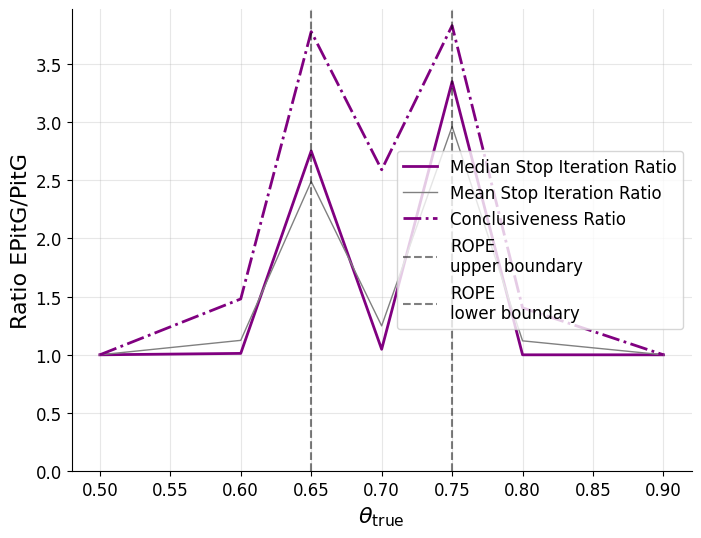

In [142]:
plot_stop_and_conclusive_ratios(hypo0pt7_algo_stats_df, subset_name = "overall", param_null=null_rate_loaded, dsuccess_rate=dsuccess_rate, viz_mean=True)
